In [1]:
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import zfit
# mplhep.style.use("LHCb2")
import modplot
import numpy as np
import pandas as pd
import uproot


gpus = tf.config.experimental.list_physical_devices('GPU')
print(tf.__version__)

2024-03-11 12:43:30.538277: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 12:43:31.054611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 12:43:32.775921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress 

2.13.0


2024-03-11 12:43:37.639224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 12:43:37.774800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 12:43:37.774865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# OmniFold


In [2]:
D0masMin = 1.75
D0masMax = 2.0
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"
nEvents=10000000
# centralityBins=[0,10]   # corresponds to 0 bin
centralityBins=[10,40] # corresponds to 1 bin
# centralityBins=[40,80] # corresponds to 2 bin

# centralityBins=[0,80] # corresponds to 2 bin


# features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3","eta"]
features = [ "pt", "z", "lambda_1_1","eta" ]

isClosureTest = True
tag = "ver0"







saveFolder = f"realData/centrality{centralityBins[0]}_{centralityBins[1]}"
if isClosureTest:
    saveFolder =f'closureTest/centrality{centralityBins[0]}_{centralityBins[1]}'

saveFolder = saveFolder + f'/{tag}'

import os
os.makedirs(saveFolder, exist_ok=True)


## ZFit 
Returns weights for centrality


In [3]:
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(D0masMin, D0masMax))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]


def getEfficiencyD0Yield(pT, centrality):
    # 2014 efficiency
    #                   0-10% ,  10-20% , 20-40% , 40-60% ,  60-80%
    efficiencies = [ [0.000622, 0.000740, 0.00088, 0.00108, 0.00140],         #for pT in range 0-0.5
                     [0.000717, 0.000717, 0.00110, 0.00143, 0.00160],         #for pT in range 0.5-1.0
                     [0.001025, 0.001300, 0.00195, 0.00304, 0.00289],         #for pT in range 1.0-1.5
                     [0.002248, 0.003014, 0.00411, 0.00610, 0.00528],         #for pT in range 1.5-2.0
                     [0.003794, 0.006104, 0.00738, 0.01072, 0.00997],         #for pT in range 2.0-2.5
                     [0.006107, 0.009671, 0.01006, 0.01606, 0.01447],         #for pT in range 2.5-3.0
                     [0.011249, 0.016457, 0.02087, 0.02565, 0.02482],         #for pT in range 3.0-4.0
                     [0.015830, 0.023905, 0.02984, 0.03553, 0.03663],         #for pT in range 4.0-5.0
                     [0.026520, 0.034723, 0.04134, 0.04656, 0.04032],         #for pT in range 5.0-6.0
                     [0.029904, 0.040095, 0.04888, 0.05334, 0.05080],         #for pT in range 6.0-8.0
                     [0.032680, 0.045229, 0.05514, 0.06017, 0.05685] ]        #for pT in range 8.0-30
    
    ptBins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 40]
    centBins = [0, 10, 20, 40, 60, 80]
    pT_range = 0
    centr_range = 0
    for i in range(len(ptBins)):
        if pT >= ptBins[i] and pT < ptBins[i+1]:
            pT_range = i
            break
    for i in range(len(centBins)):
        if  centrality >= centBins[i] and centrality < centBins[i+1]:
            centr_range = i
            break
    return efficiencies[pT_range][centr_range]

#     //https://inspirehep.net/literature/2051708
#     // https://journals.aps.org/prc/abstract/10.1103/PhysRevC.99.034908

# //D0 2014 efficiency                        0-10% ,     10-20% , 20-40% ,  40-60%  60-80%
#     const double efficiencies[11][5]={     {0.000622, 0.000740, 0.00088, 0.00108, 0.00140},         //pT = 0-0.5
#                                            {0.000717,0.000717, 0.00110, 0.00143, 0.00160},          //pT = 0.5-1.0
#                                            {0.001025, 0.001300, 0.00195, 0.00304, 0.00289},         //pT = 1.0-1.5
#                                            {0.002248, 0.003014, 0.00411, 0.00610, 0.00528},         //pT = 1.5-2.0
#                                            {0.003794,0.006104, 0.00738, 0.01072, 0.00997},          //pT = 2.0-2.5
#                                            {0.006107, 0.009671, 0.01006, 0.01606, 0.01447},         //pT = 2.5-3.0
#                                            {0.011249, 0.016457, 0.02087, 0.02565, 0.02482},         //pT = 3.0-4.0
#                                            {0.015830, 0.023905, 0.02984, 0.03553, 0.03663},         //pT = 4.0-5.0
#                                            {0.026520, 0.034723,   0.04134, 0.04656,0.04032},          //pT = 5.0-6.0
#                                            {0.029904, 0.040095,0.04888, 0.05334,0.05080},           //pT = 6.0-8.0
#                                            {0.032680,0.045229,    0.05514,0.06017,0.05685} };         //pT = 8.0-10.0

#     //https://drupal.star.bnl.gov/STAR/system/files/2018_1109_D0spectra_Note.pdf
#     //D0 2016 efficiency                        0-10%       10-20%  20-40%   40-60%      60-80%
#     const double efficiencies2016[11][5] = {  {0.000669, 0.000741, 0.000845, 0.000981, 0.001094},    //pT = 0-0.5
#                                               {0.000741, 0.000707, 0.001018, 0.001216, 0.001305},    //pT = 0.5-1.0
#                                               {0.001037, 0.001285, 0.001957, 0.002952, 0.002222},    //pT = 1.0-1.5
#                                               {0.002358, 0.002978, 0.004169, 0.005517, 0.004192},    //pT = 1.5-2.0
#                                               {0.004128, 0.006111, 0.007096, 0.009658, 0.008442},    //pT = 2.0-2.5
#                                               {0.006282, 0.009654, 0.010210, 0.014426, 0.012034},    //pT = 2.5-3.0
#                                               {0.012071, 0.016277, 0.020178, 0.024096, 0.020480},    //pT = 3.0-4.0
#                                               {0.018021, 0.023850, 0.028217, 0.033696, 0.029730},    //pT = 4.0-5.0
#                                               {0.026160, 0.034300, 0.042521, 0.047122, 0.033852},    //pT = 5.0-6.0
#                                               {0.029773, 0.039774, 0.047944, 0.051664, 0.038528},    //pT = 6.0-8.0
#                                               {0.032934, 0.044408, 0.054539, 0.058225, 0.043018} }; //pT = 8.0-10.0
# }

2024-03-11 12:43:37.847670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 12:43:37.847824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 12:43:37.847851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 12:43:40.643512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-11 12:43:40.644566: I tensorflow/compile

In [4]:
# with uproot.open("/home/prozorov/dev/star/unfold/JetFinderEfficiency.root") as file:
#     hist=file["JetFinderEfficiency"] #2d histogram
#     eff=hist.to_numpy()
#     values = eff[0]
#     ptBinsEdges = eff[1]
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
# centrality : 0-10%,     10-40%,    40-80%
values =  [ [0.8040493,  0.83887934, 0.91436481],
            [0.83531431, 0.87066498, 0.93592894],
            [0.86378964, 0.89502397, 0.94950428],
            [0.8858829,  0.91200534, 0.95879075],
            [0.90171456, 0.92392761, 0.96557282],
            [0.91389318, 0.93324831, 0.97033296],
            [0.92173535, 0.94047693, 0.97348525],
            [0.92743685, 0.94662845, 0.97777634],
            [0.93525452, 0.94907014, 0.97975429],
            [0.94756974, 0.95762499, 0.98211105],
            [0.95040946, 0.96266307, 0.98382422],
            [0.96602388, 0.96608892, 0.98780008],
            [0.96862745, 0.96307934, 0.99102773]
]
def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(values)):
        ptBin=len(values)-1
    return values[ptBin][centralityBin]

## Setup the Datasets

In [5]:

centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]

# make centrality dependent analysis
print("Processing centrality bin: ", centralityCuts[0])

embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
exp_tree       = uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets")

exp = exp_tree.arrays(["D0_pT","D0mass", "centrality", "centr_weight", "jet_pt_corr","pseudorapidity",
                       "z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3"], 
                       cut=D0ExpCut, library='pd')
#apply centrality cut
mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}
exp["centrality"]  = exp["centrality"].apply(lambda x: mapCentrality[x])
jetFilter =(exp["centrality"]>=centralityBins[0]) & (exp["centrality"]<centralityBins[1])
exp = exp.loc[jetFilter]
expcopy = exp.copy()
exp["SWeight"] = getSWeights(expcopy)

print(exp.head())
exp["Eff"] = exp.apply(lambda row: getEfficiencyD0Yield(row["D0_pT"], row["centrality"]), axis=1)
print(exp.head())
exp["Weight"] = exp["SWeight"]*exp["Eff"]*exp["centr_weight"]
print(exp.head())

exp.drop(columns=["SWeight", "Eff", "centr_weight", "D0_pT","D0mass", "centrality"], inplace=True)
exp.rename(columns={"jet_pt_corr": "pt","pseudorapidity":"eta"}, inplace=True)


columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3", "McJetEta",
            "RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetEta", "Centrality", "Weight" ]
sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts[0] + "& (RecoJetNConst!=0)", library="pd", entry_stop=nEvents)

centralityBinMap = {0:0, 10:1, 40:2}
sim_mc_reco["Weight"] = sim_mc_reco["McJetPt"].apply( lambda pt: getSimJetFinderEfficiency(pt, centralityBinMap[centralityBins[0]]))

print("Data events: ", len(exp))
print("MC events: ", len(sim_mc_reco))

print(exp.head())


Processing centrality bin:  (Centrality >= 10) & (Centrality < 40)
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr  pseudorapidity  \
22  2.334607  1.885678          10      0.874758     7.425858       -0.488506   
25  3.340305  1.873526          10      0.844429     6.175816        0.305805   
28  2.571586  1.833027          20      0.900463     0.549912       -0.364026   
30  1.516271  1.807254          10      0.800334     1.274299       -0.174573   
32  2.859297  1.953037          10      0.887649     5.182415       -0.251921   

           z  lambda_1_1  lambda_1_1half  lambda_1_2  lambda_1_3   SWeight  
22  0.312592    1.016062        0.780407    0.619827    0.424211  1.009444  
25  0.559788    1.659543        1.333393    1.107754    0.831131  1.164663  
28  6.356561    8.628114        6.528537    5.211523    3.735270  0.536414  
30  1.414218    5.559418        4.298618    3.423204    2.291266 -0.379005  
32  0.583649    2.309980        1.985521    1.763299    1.480

In [6]:
genMcFeatures = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3","McJetEta"]
recoMcFeatures = ["RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","RecoJetEta"]


genMcJets = sim_mc_reco[genMcFeatures].copy()
genMcJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3", "McJetEta" : "eta"}, inplace=True)
genMcJets["Weight"] = sim_mc_reco["Weight"]

recoMcJets = sim_mc_reco[recoMcFeatures].copy()
recoMcJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3", "RecoJetEta" : "eta"}, inplace=True)
recoMcJets["Weight"] = sim_mc_reco["Weight"] 

assert genMcJets.shape == recoMcJets.shape
assert genMcJets.shape == recoMcJets.shape

print("genMcJets: ", genMcJets.head(20))
print("recoMcJets: ", recoMcJets.head(20))

## Closure test on embedding
trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)

## Train on MC, test on data 
if not isClosureTest:
    trainGen = genMcJets
    trainReco = recoMcJets
    testReco = exp

genMcJets:            pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
0   4.536747  0.877385  7.901379e-02    1.957291e-02  5.858880e-03   
1   1.183083  1.000000  3.598196e-17    1.365077e-25  5.178806e-34   
3   5.909576  0.805683  1.417998e-01    4.436306e-02  1.600768e-02   
6   2.527555  0.800979  1.617472e-01    6.532054e-02  3.226269e-02   
9   3.124506  1.000000  3.197549e-19    1.143552e-28  4.089729e-38   
10  2.337425  1.000000  4.662069e-17    2.013252e-25  8.693956e-34   
14  2.186589  0.746242  3.764709e-01    1.613805e-01  7.393552e-02   
18  3.963038  0.831418  9.695656e-02    2.026867e-02  4.240199e-03   
24  1.535676  1.000000  1.382358e-17    3.250579e-26  7.643652e-35   
30  2.923259  0.769023  9.677034e-02    2.170402e-02  4.867859e-03   
33  3.361486  0.887978  9.964150e-02    2.110355e-02  4.469621e-03   
40  2.570060  1.000000  5.075421e-17    2.286853e-25  1.030396e-33   
42  4.994942  0.735206  1.481237e-01    4.042516e-02  1.110352e-02   
43  2.12

## Unfold Data

In [7]:
corr = trainGen.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=3))




,pt,z,lambda_1_1,lambda_1_1half,lambda_1_2,lambda_1_3,eta,Weight
pt,nan,nan,nan,nan,nan,nan,nan,nan
z,-0.394,nan,nan,nan,nan,nan,nan,nan
lambda_1_1,0.291,-0.816,nan,nan,nan,nan,nan,nan
lambda_1_1half,0.275,-0.778,0.986,nan,nan,nan,nan,nan
lambda_1_2,0.268,-0.731,0.959,0.991,nan,nan,nan,nan
lambda_1_3,0.260,-0.631,0.880,0.934,0.971,nan,nan,nan
eta,-0.003,0.006,-0.007,-0.007,-0.007,-0.008,nan,nan
Weight,0.915,-0.403,0.314,0.292,0.283,0.272,-0.004,nan


In [8]:
iterations = 5

In [9]:
# Processed MC reco data for training

X_det = np.concatenate((trainReco[features],testReco[features]))
# labels0 = {0}, labels_unknown = {1} 
Y_det = np.concatenate((np.zeros(trainReco.shape[0]),np.ones(testReco.shape[0])))

# Processed MC truth data data for training
X_gen = np.concatenate((trainGen[features], trainGen[features]))
Y_gen = np.concatenate((np.zeros(trainGen.shape[0]), np.ones(trainGen.shape[0])))


# scaler = StandardScaler()
# X_det = scaler.fit_transform((pd.concat([ testReco[features],trainReco[features]], ignore_index=True, sort=False)))
# Y_det = np.concatenate((np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0])))

# X_gen = scaler.fit_transform((pd.concat([trainGen[features], trainGen[features]], ignore_index=True, sort=False)))
# Y_gen = np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0])))

# Push and pull weights in unfolding
weights = np.empty(shape=(iterations, 2, len(trainReco)))

# shape = (#iteration, #step, #event)

# Normalization layer for input variables
normalizerLayer = tf.keras.layers.Normalization()
normalizerLayer.adapt(pd.concat([testReco[features]]))

# tensorflow DNN model 
inputs = Input((len(features),)) #  vector of number of features as input
normalized_layer = normalizerLayer(inputs)
# three hidden layers 
hidden_layer_1 = Dense(100, activation='relu')(normalized_layer)
hidden_layer_2 = Dense(100, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(100, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_2)
model = Model(inputs=inputs, outputs=outputs)

# Early stopping criteria to avoid overtraining
earlystopping = EarlyStopping(patience=3,
                              verbose=1,
                              restore_best_weights=True)





In [10]:
print ("X_det: ", X_det.shape)
print ("Y_det: ", Y_det.shape)

print ("X_gen: ", X_gen.shape)
print ("Y_gen: ", Y_gen.shape)

print (trainReco[features].shape,testReco[features].shape)

print ("ratio of exp to sim: ", len(testReco)/len(trainReco))


X_det:  (3758143, 4)
Y_det:  (3758143,)
X_gen:  (6013028, 4)
Y_gen:  (6013028,)
(3006514, 4) (751629, 4)
ratio of exp to sim:  0.2500001663055619


In [11]:
trainWts = trainGen["Weight"]
trainWts = trainWts/trainWts.mean()
trainWts = np.ones(len(trainWts))
print("Sum of training weights: ", trainWts.sum())

testWts = testReco["Weight"]
testWts = testWts/testWts.mean()
print("Sum of testing weights: ", testWts.sum())

ndata, nsim = np.count_nonzero(Y_det), np.count_nonzero(Y_det==0)

trainWts= (ndata/nsim)*trainWts
if isClosureTest:
     testWts = np.ones(ndata)

#  reweight the sim and data to have the same total weight to begin with
print ("ndata = ", ndata)
print ("nsim = ", nsim)

# # Push and pull weights in unfolding
# # initial iterative weights are the nominal weight
weights_pull = trainWts
weights_push = trainWts

w_data = testWts


print(np.sum(testWts), np.sum(trainWts))


Sum of training weights:  3006514.0
Sum of testing weights:  751628.9999999998
ndata =  751629
nsim =  3006514
751629.0 751629.0000000051


In [12]:
testWts

array([1., 1., 1., ..., 1., 1., 1.])

In [13]:
trainWts

array([0.25000017, 0.25000017, 0.25000017, ..., 0.25000017, 0.25000017,
       0.25000017])

In [14]:
import omnifold_new as of
import importlib
importlib.reload(of)

weights = of.omnifold(trainGen[features], trainReco[features], testReco[features], trainWts, testWts, iterations, model,1)



ITERATION: 1

STEP 1

Epoch 1/100


2024-03-11 12:45:06.112578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-11 12:45:06.221802: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdba8948750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 12:45:06.221909: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-11 12:45:06.326440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-11 12:45:06.447746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-03-11 12:45:06.797919: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 

282/282 [==============================] - 6s 7ms/step - loss: 0.2773 - accuracy: 0.2972 - val_loss: 0.2773 - val_accuracy: 0.2464
Epoch 2/100
282/282 [==============================] - 2s 6ms/step - loss: 0.2773 - accuracy: 0.2927 - val_loss: 0.2773 - val_accuracy: 0.3851
Epoch 3/100
282/282 [==============================] - 1s 5ms/step - loss: 0.2773 - accuracy: 0.3019 - val_loss: 0.2773 - val_accuracy: 0.2717
Epoch 3: early stopping
301/301 [==============================] - 0s 1ms/step

STEP 2

Epoch 1/100
451/451 [==============================] - 4s 6ms/step - loss: 0.1738 - accuracy: 0.2498 - val_loss: 0.1737 - val_accuracy: 0.2499
Epoch 2/100
451/451 [==============================] - 2s 6ms/step - loss: 0.1737 - accuracy: 0.2499 - val_loss: 0.1737 - val_accuracy: 0.2498
Epoch 3/100
451/451 [==============================] - 2s 6ms/step - loss: 0.1737 - accuracy: 0.2499 - val_loss: 0.1737 - val_accuracy: 0.2498
Epoch 4/100
451/451 [==============================] - 2s 6ms/step

In [15]:
weights


array([[[0.25234817, 0.25543495, 0.24961715, ..., 0.25380256,
         0.25195505, 0.25433936],
        [1.00706327, 1.0058161 , 1.00836825, ..., 1.00706446,
         1.01503694, 1.00527596]],

       [[0.2520209 , 0.25327259, 0.25401577, ..., 0.25302702,
         0.25490525, 0.24874927],
        [0.99961007, 1.01227498, 1.01289737, ..., 0.99578029,
         1.01556087, 1.00997484]],

       [[0.24311592, 0.25172776, 0.24388285, ..., 0.2476825 ,
         0.24339983, 0.24823612],
        [0.98411918, 1.0157795 , 0.99181259, ..., 0.98140526,
         0.96164364, 1.01138842]],

       [[0.24358144, 0.24855612, 0.25085893, ..., 0.24262479,
         0.24468721, 0.25315526],
        [0.97449261, 0.99577552, 0.98068517, ..., 0.97300416,
         0.96536088, 0.99904585]],

       [[0.2452959 , 0.24669856, 0.25464928, ..., 0.24327992,
         0.24451551, 0.25546846],
        [0.99223256, 1.00971389, 1.00560784, ..., 0.99302942,
         1.02064872, 1.02621984]]])

In [16]:
## from NN (DCTR)
# def reweight(events):
#     f = model.predict(events, batch_size=5*2000)
#     weights = f / (1. - f)
#     return np.squeeze(np.nan_to_num(weights))    
# #Question: how is the model passed? Stored in memory before function is called?
# #QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
# #reweights sim to data, then 
    
# for i in range(iterations):
#     print("\nITERATION: {}\n".format(i + 1))

#     # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
#     # weights reweighted Sim. --> Data
#     print("STEP 1\n")

#     # weights_push = weights from previous interation
#     # w_data is the "real" data
#     weights_det = np.concatenate((weights_push,w_data))

#     X_train_det, X_test_det, Y_train_det, Y_test_det, w_train_det, w_test_det = train_test_split(
#         X_det, Y_det, weights_det)

#     model.compile(loss= 'binary_crossentropy',
#                   optimizer='Adam',
#                   metrics=['accuracy']
#     )
#     # Classification at reco level
#     model.fit(X_train_det, 
#               Y_train_det,
#               sample_weight=w_train_det,
#               epochs=200,
#               batch_size=2000,
#               validation_data=(X_test_det, Y_test_det, w_test_det),
#               callbacks=[earlystopping],
#               verbose=1)

#     # reco events weights after reco level reweight
#     weights_pull = weights_push * reweight(trainReco[features])
#     weights[i, :1, :] = weights_pull

#     # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
#     # weights Gen. --> reweighted Gen.
#     print("\nSTEP 2\n")

#     # "Signal" is MC truth events after reco level reweight, "background" is the un-weighted true MC events

#     weights_model = np.concatenate(( trainWts,weights_pull))
#     # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

#     X_train_model, X_test_model, Y_train_model, Y_test_model, w_train_model, w_test_model = train_test_split(
#         X_gen, Y_gen, weights_model)

#     model.compile(loss= 'binary_crossentropy',
#                   optimizer='Adam',
#                   metrics=['accuracy'])
#     model.fit(X_train_model,
#               Y_train_model,
#               sample_weight=w_train_model,
#               epochs=200,
#               batch_size=5*2000,
#               validation_data=(X_test_model, Y_test_model, w_test_model),
#               callbacks=[earlystopping],
#               verbose=1)

#     # weights after truth level reweight
#     weights_push = trainWts*reweight(trainGen[features])
#     ### 
    
#     weights[i, 1:2, :] = weights_push

In [17]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})
# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'bins_mc':[1,3,5,7,10,13,20,30],
    'bins_det':[-10,-5,-1,1,3,5,7,10,13,16,20,30,40],
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (1, 30), 'ylim': (0.000003, 10),
    'xlim_det': (-10, 40),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.6, 0.75),
    'legend_loc': 'upper right'
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0.1, 1.001),  'ylim': (0, 3),
    'xlim_det': (-15, 15),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.8), 'ylim': (0, 6),
    'xlim_det': (-15, 15),   
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.35), 'ylim': (0, 10),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.15), 'ylim': (0, 10),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (0, 0.06), 'ylim': (0, 10),
    'xlim_det': (-15, 15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('eta', {}).update({
    'nbins_det': 40, 'nbins_mc': 20,
    'xlim': (-1, 1),
    'xlim_det': (-1, 1),  
    'xlabel': r'Jet  $\eta$', 'symbol': r'$\eta$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': 'none', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}


plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}


for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins if they are not present
    if 'bins_det' not in ob:
        ob['bins_det'] = np.linspace(ob['xlim_det'][0], ob['xlim_det'][1], ob['nbins_det']+1)
    if 'bins_mc' not in ob:
        ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    
    ob['bins_det'] = np.array(ob['bins_det'])
    ob['bins_mc'] = np.array(ob['bins_mc'])

    # calculate midpoints of the bins 
    ob['midbins_det'] = 0.5*(ob['bins_det'][1:] + ob['bins_det'][:-1])
    ob['midbins_mc'] = 0.5*(ob['bins_mc'][1:] + ob['bins_mc'][:-1])

    # calculate widths of the bins
    ob['binwidth_det'] = ob['bins_det'][1:] - ob['bins_det'][:-1]
    ob['binwidth_mc'] = ob['bins_mc'][1:] - ob['bins_mc'][:-1]


    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
  
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
    
  
   
    print('Done with', obkey)
    

Done with pt
Done with z
Done with lambda_1_1
Done with lambda_1_1half
Done with lambda_1_2
Done with lambda_1_3
Done with eta


In [18]:
selectedIteration = iterations - 1

/tmp/ipykernel_88468/2667265795.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_88468/2667265795.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


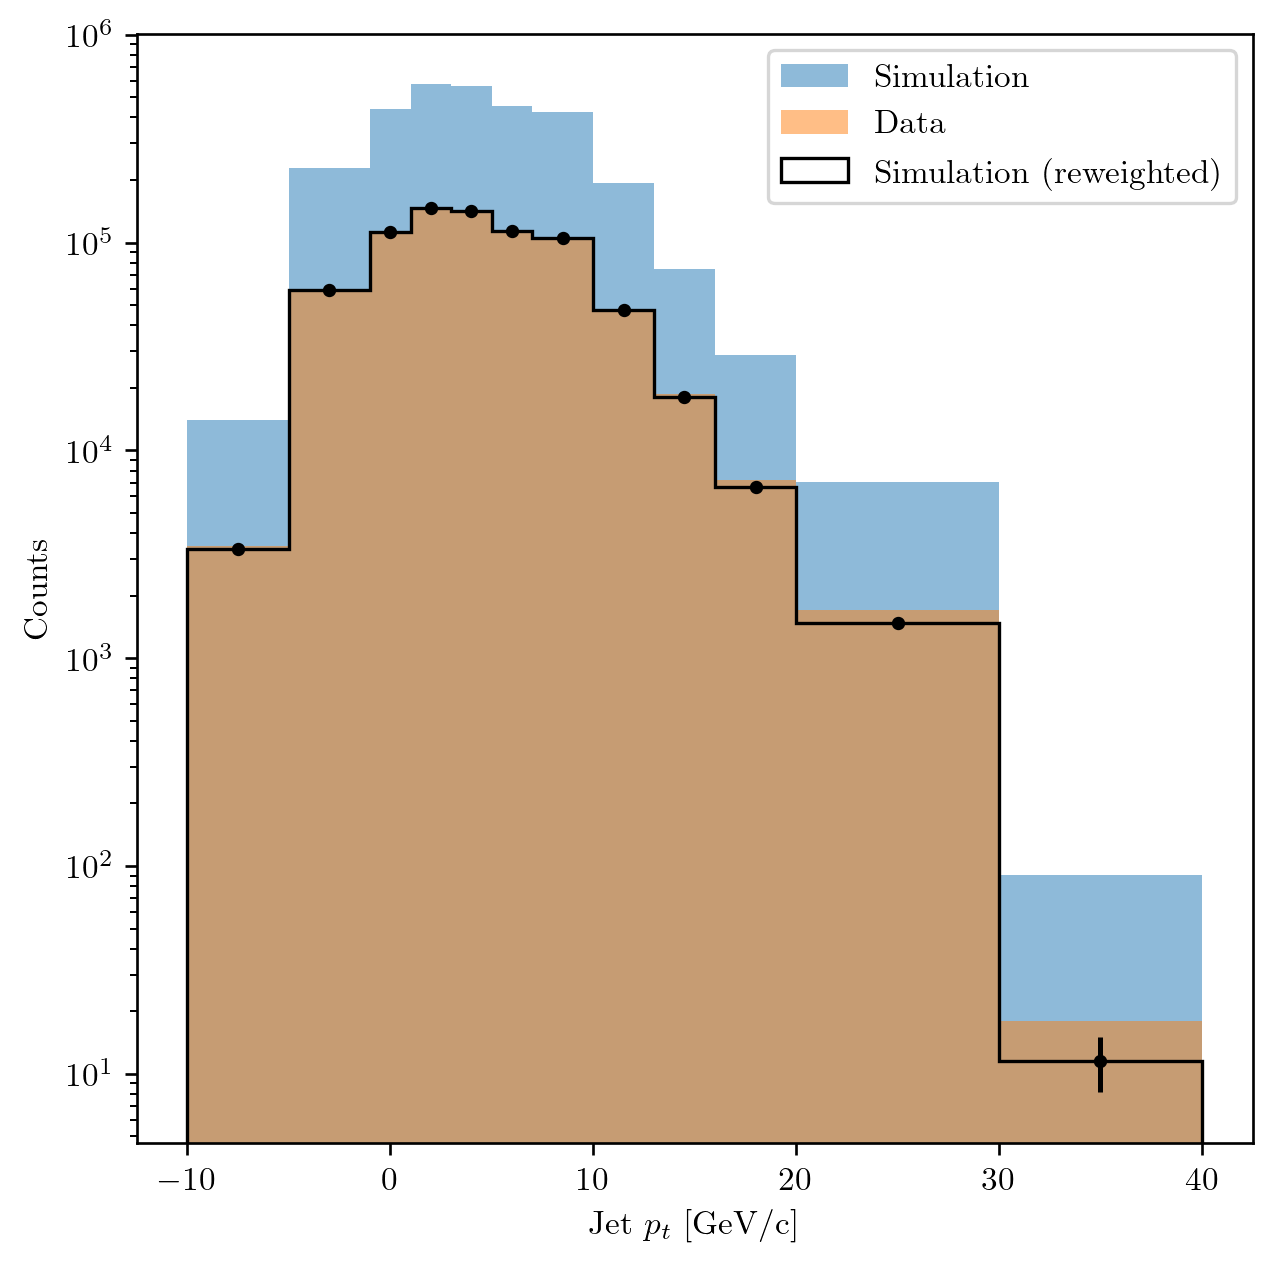

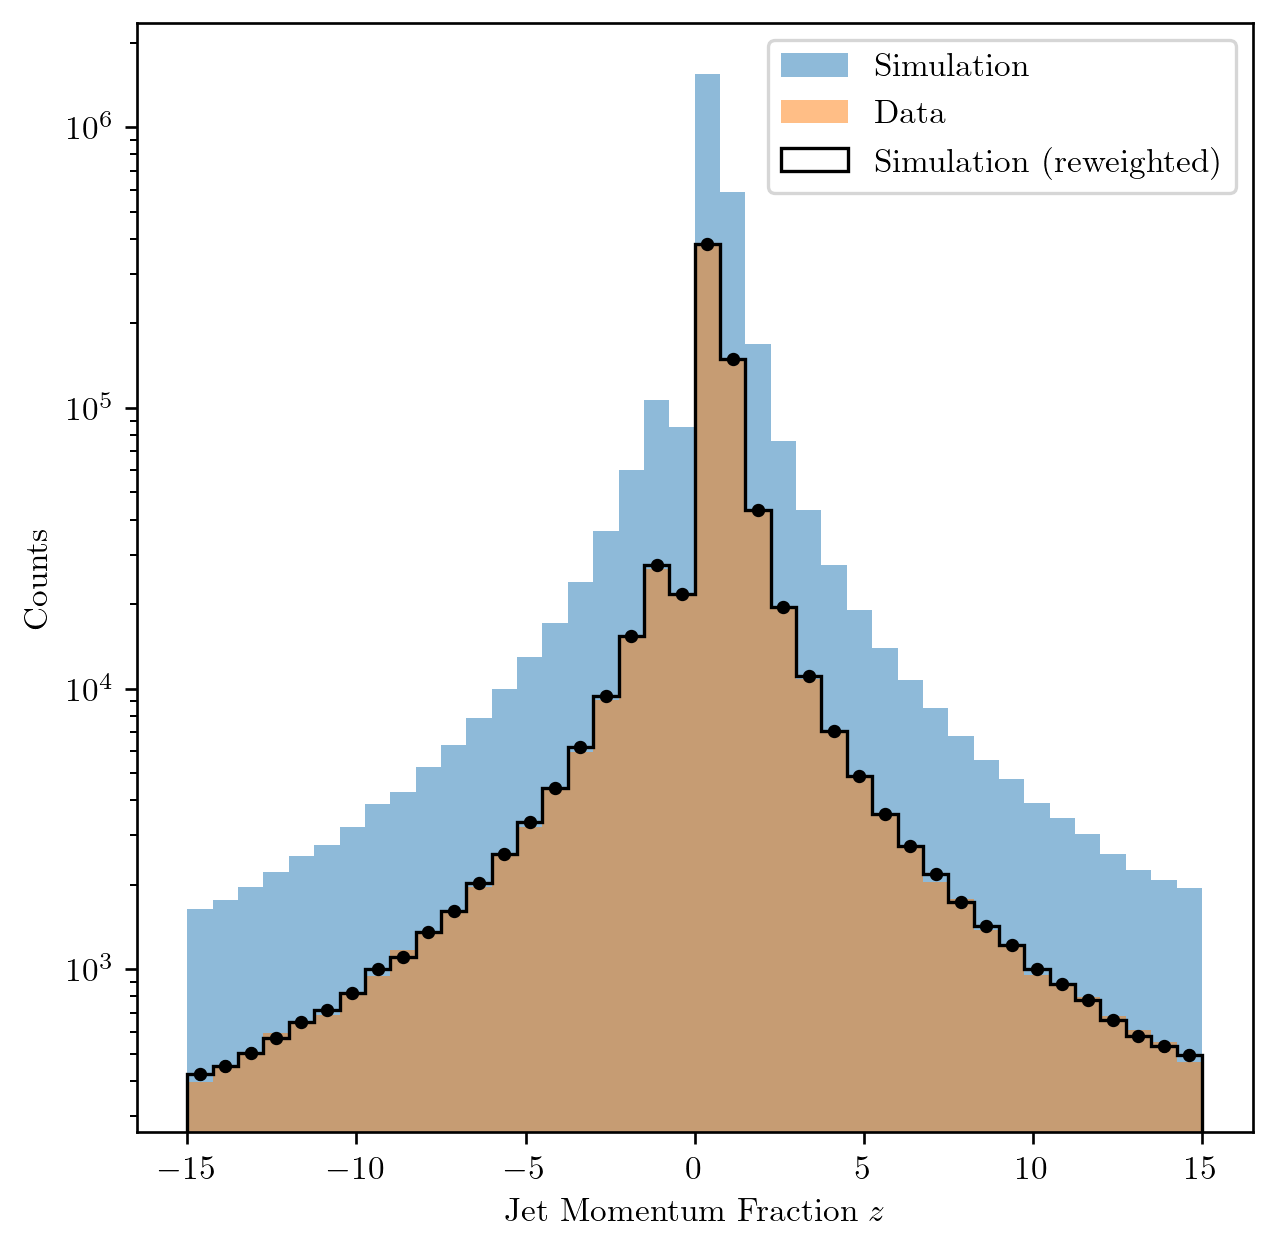

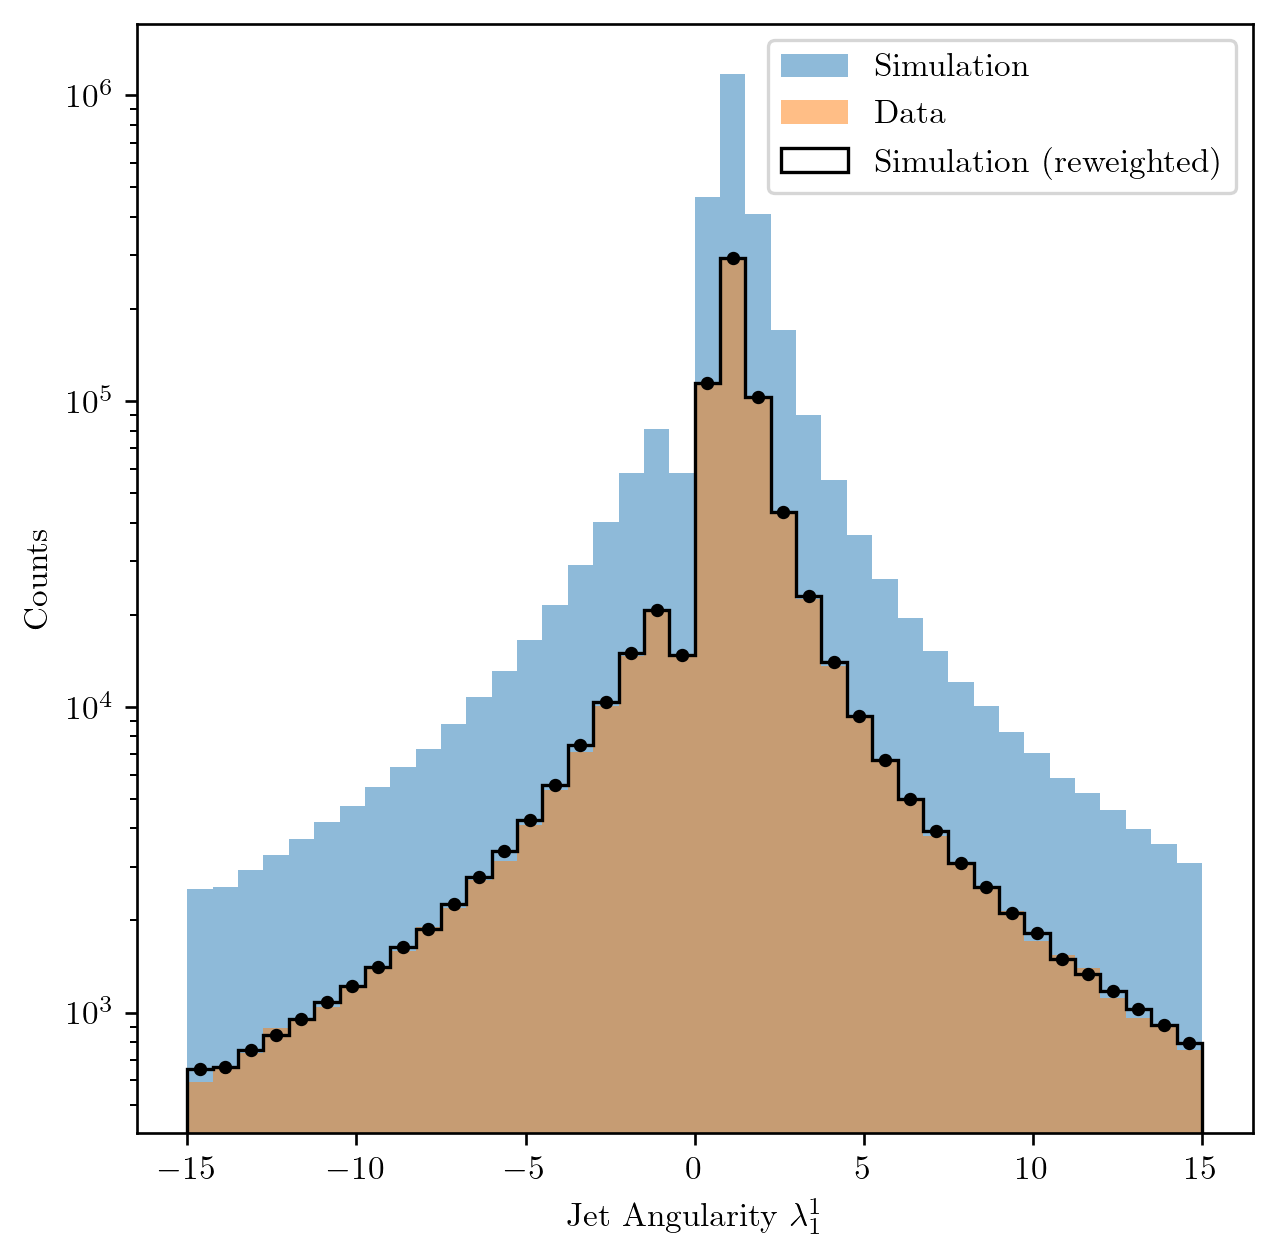

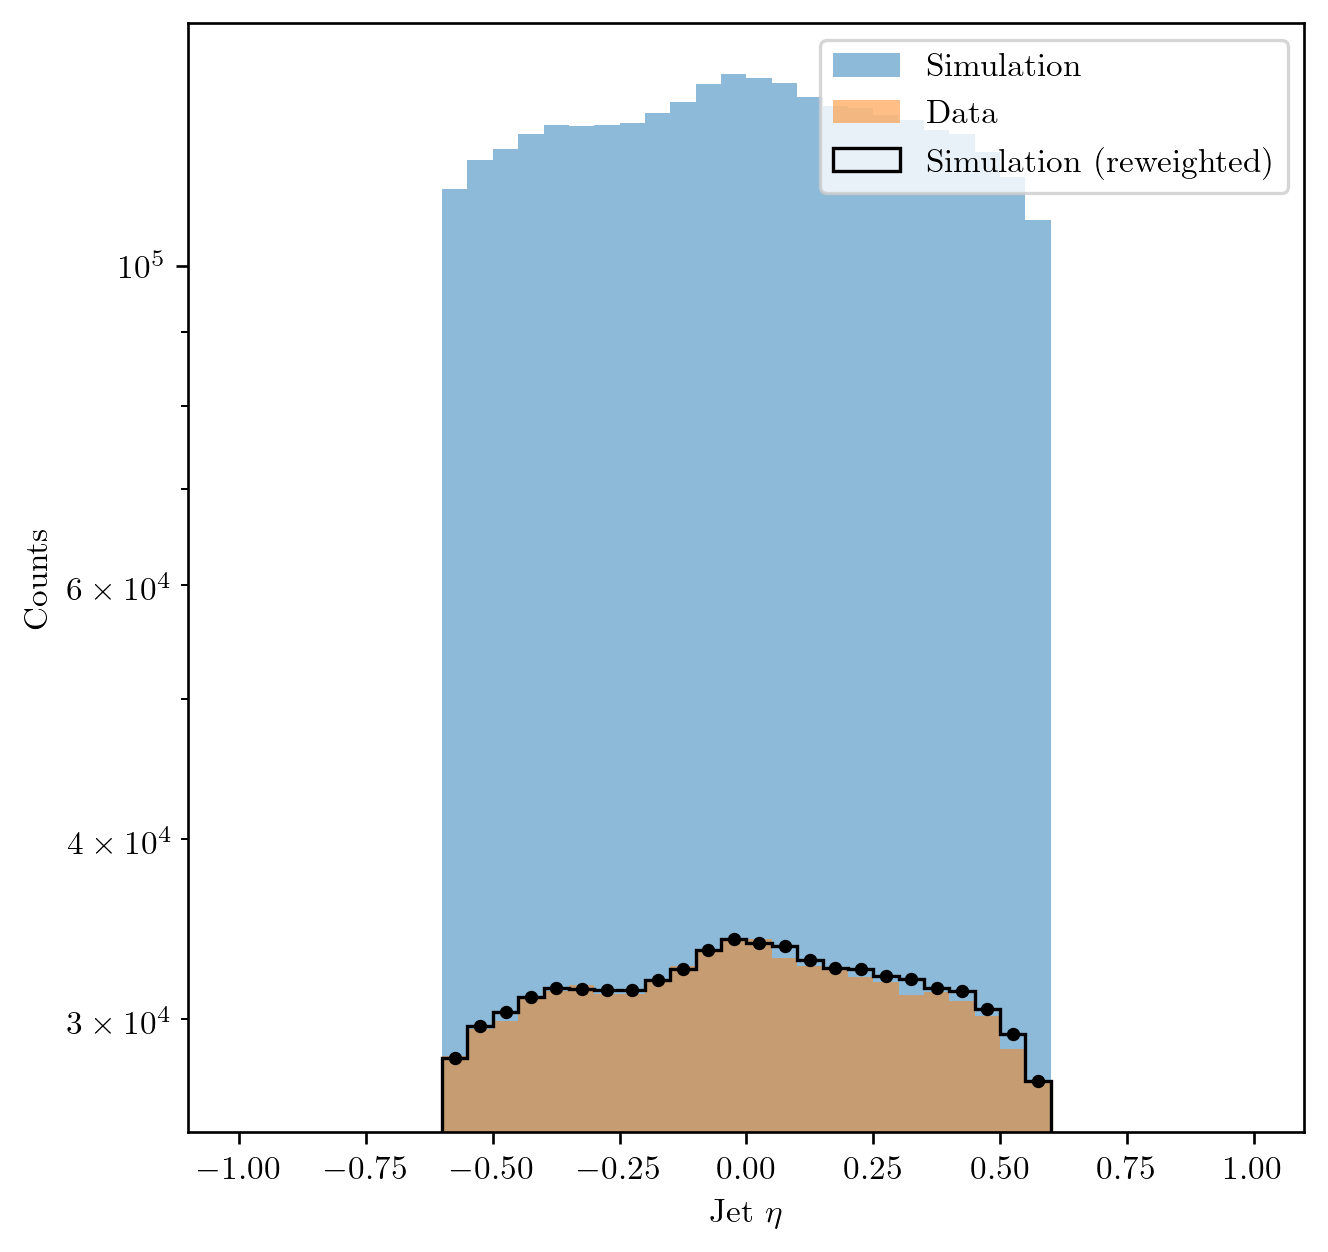

In [19]:
wdata = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1

# for i,(obkey,ob) in enumerate(obs.items()):
# terate only in those observables which are in features:
for obkey,ob in obs.items():
    if obkey not in features:
        continue
    ndata=len(testReco)
    nsim=len(trainReco)
    norm = nsim/ndata
    norm=0.5*norm
    norm=1
    plt .rcParams['figure.figsize'] = (6,6)
    plt .rcParams['figure.dpi'] = 240

    fig, ax = plt.subplots()
    
    
    ax.hist(trainReco[obkey], bins=ob['bins_det']  , **plot_style_2, label='Simulation')
    ax.hist(testReco[obkey], bins=ob['bins_det'], **plot_style_2, label='Data ', weights=norm*testWts)
    entries, edges, _ = ax.hist(trainReco[obkey], bins=ob['bins_det'], histtype="step", label='Simulation (reweighted)',color="black",weights=norm*wdata)

    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    # draw errobars, use the sqrt error. You can use what you want there
    # poissonian 1 sigma intervals would make more sense
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='k.')


    # legend = ax.legend(loc='upper left',    frameon=False)
    # plt.setp(legend.get_title(), multialignment='center')
    plt.yscale('log')
    plt.xlabel(ob['xlabel'])
    plt.ylabel(ob['ylabel'])
    plt.legend()
    fig.show()

    fig.savefig(f"{saveFolder}/reweight_{obkey}.pdf", bbox_inches='tight')

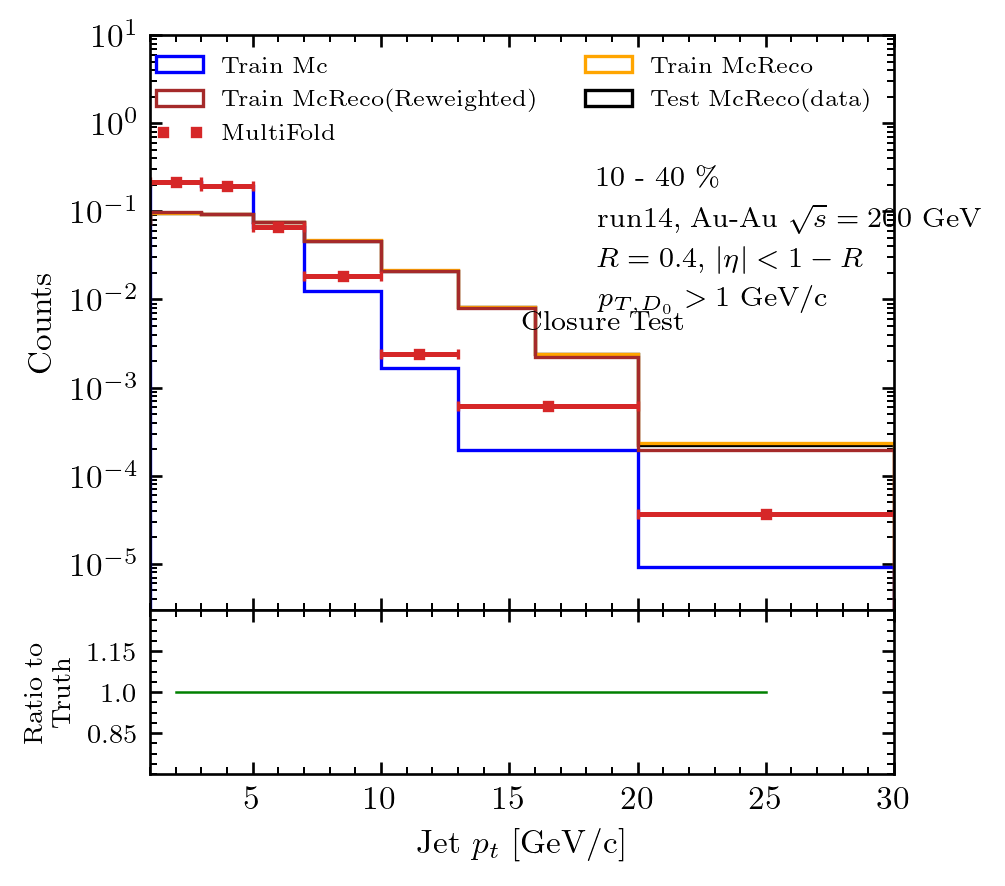

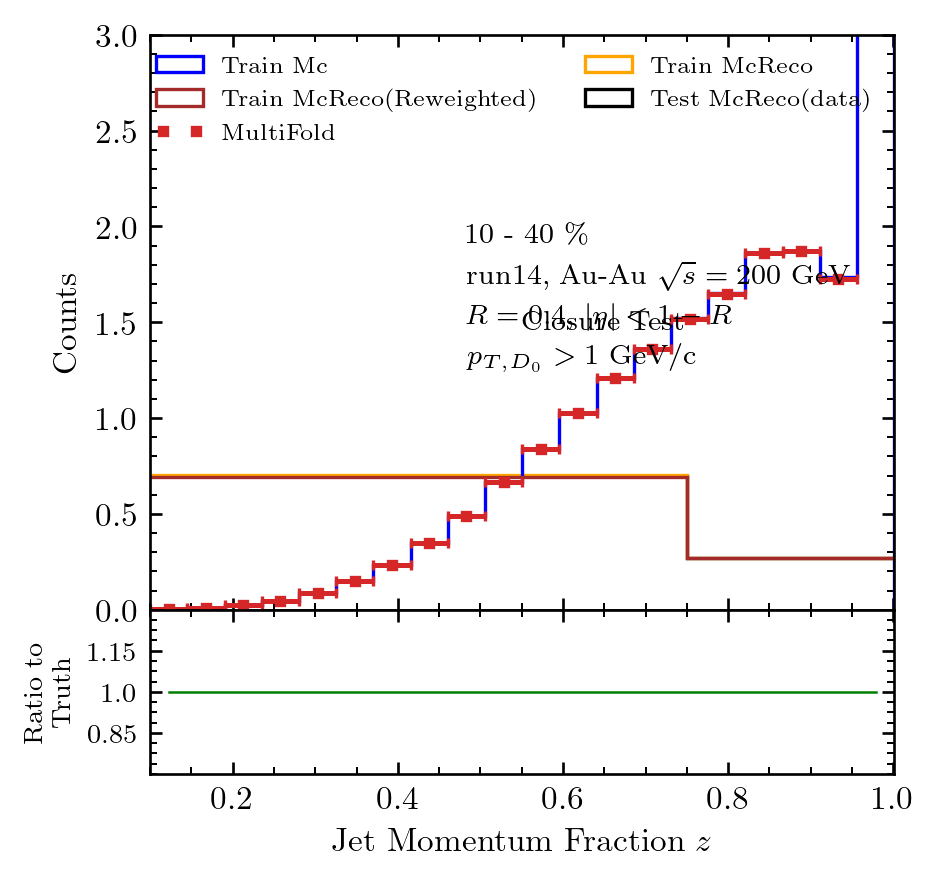

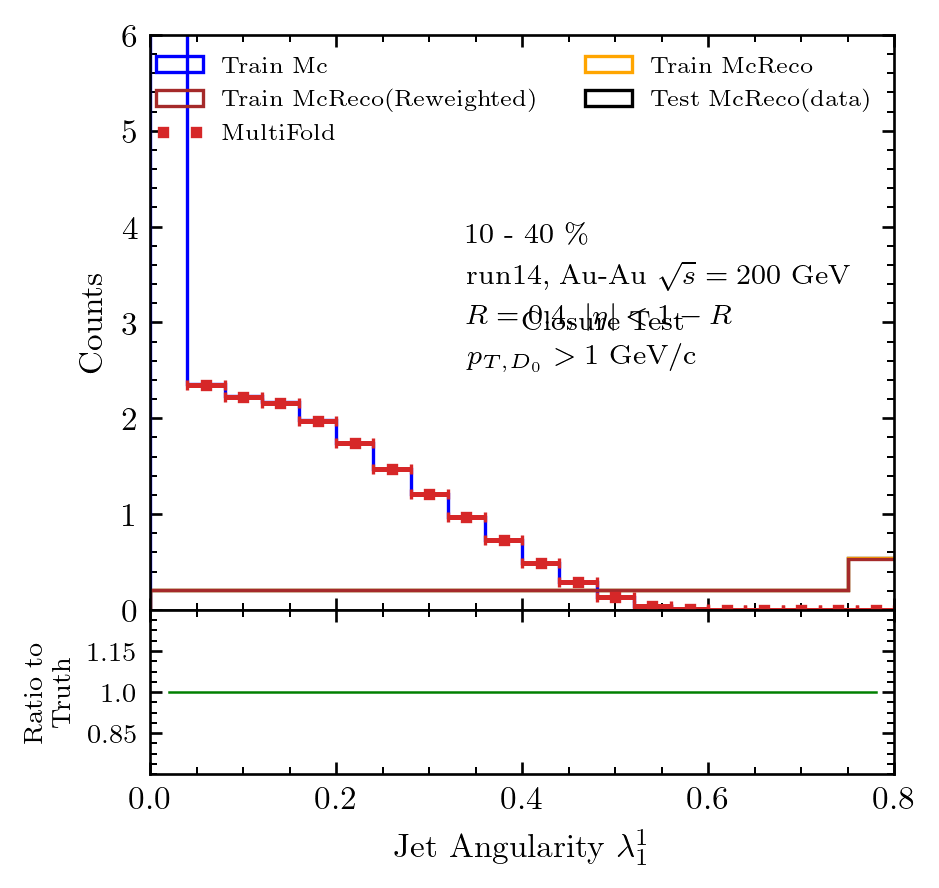

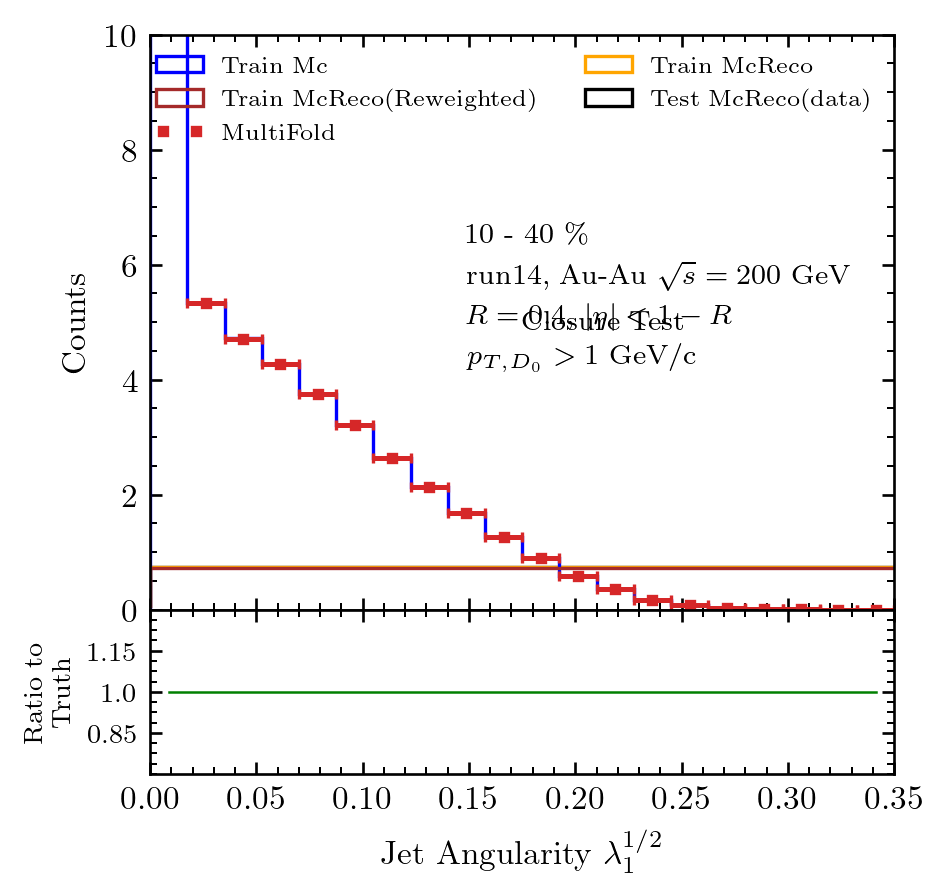

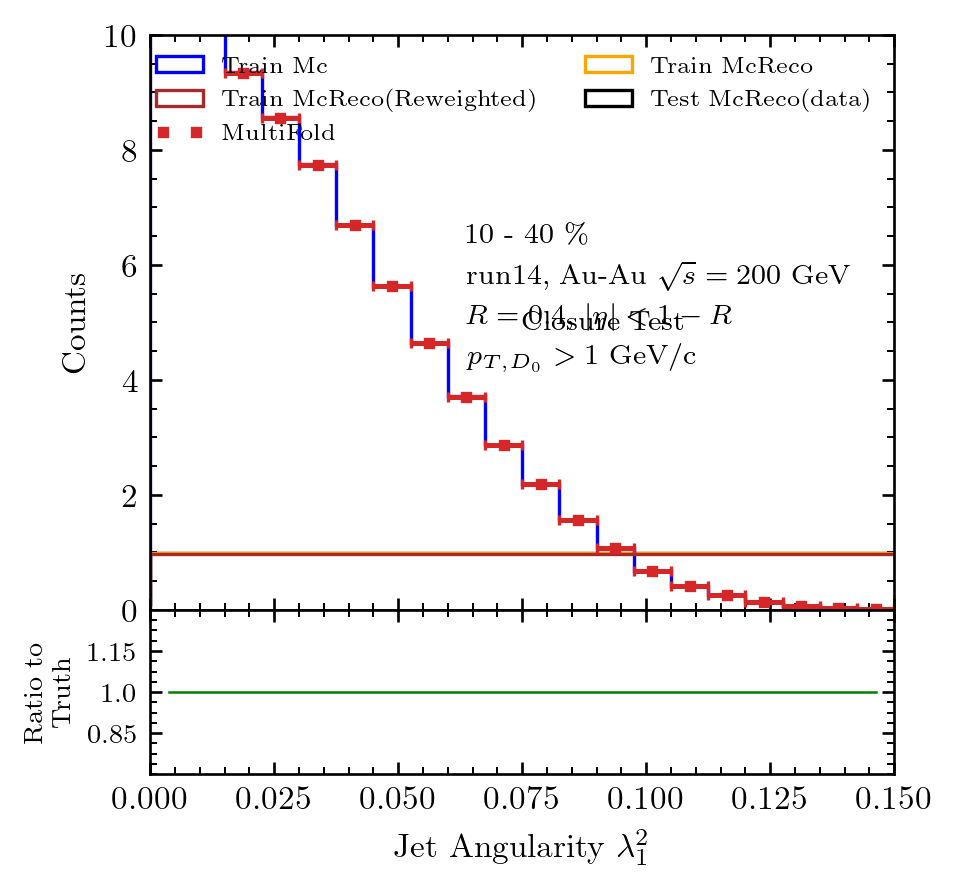

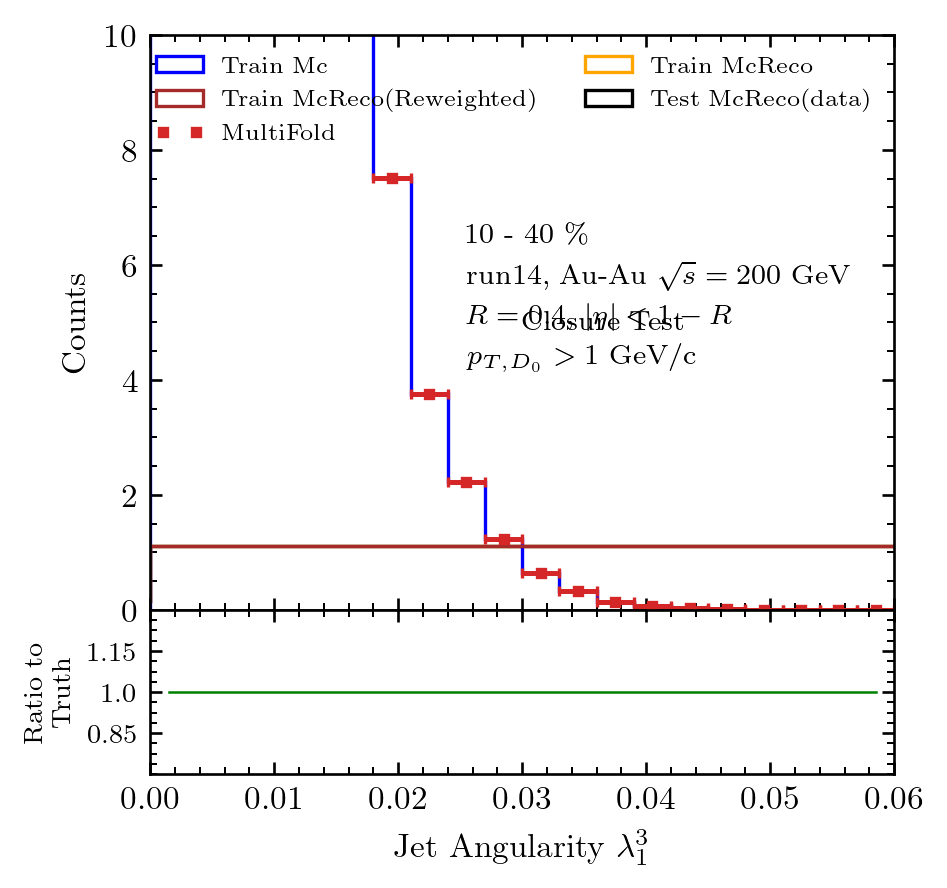

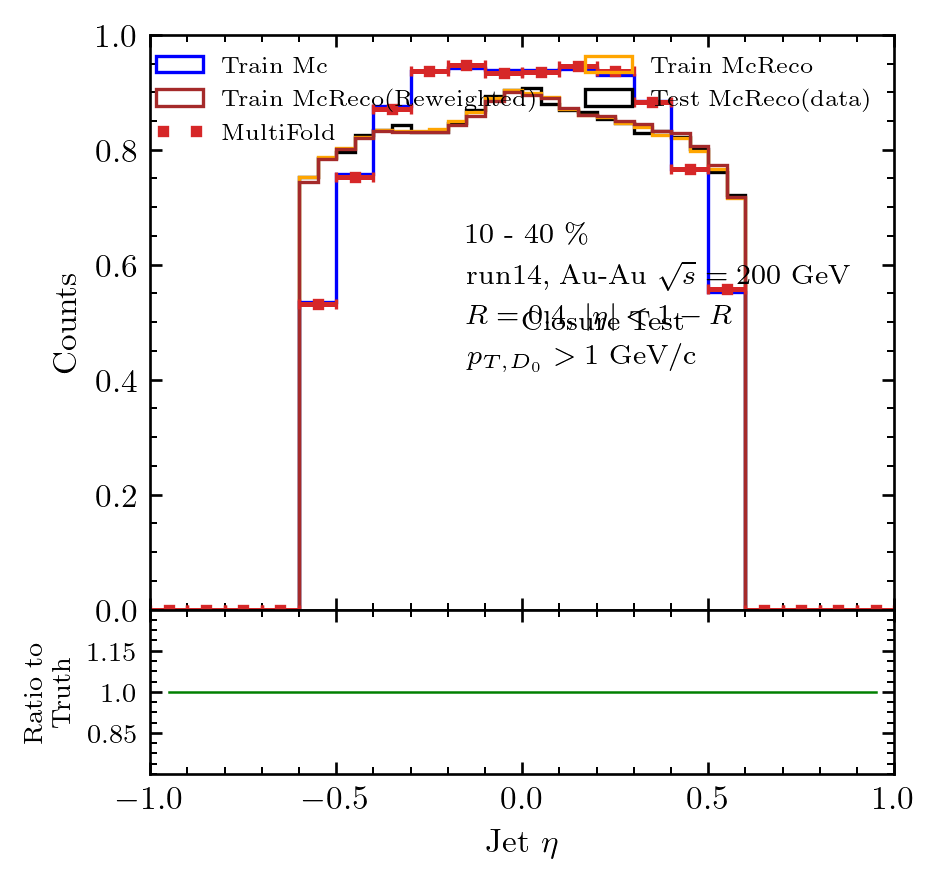

In [25]:
if isClosureTest:
    wdata = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1

    for i,(obkey,ob) in enumerate(obs.items()):
        
        # get the styled axes on which to plot
        fig, [ax0, ax1] = modplot.axes(**ob)
        if ob.get('yscale') is not None:
            ax0.set_yscale(ob['yscale'])


        # Plot the Different Distributions of the Observable
        # plot the "data" histogram of the observable
        ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='Test McReco(data)', density=True, **hist_style)


        # plot the "sim" histogram of the observable
        ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Train McReco', density=True,**hist_style)

        ax0.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='Train Mc',density=True, **hist_style)

        # # plot the "sim" histogram of the observable
        # ax0.hist(ob['truthobs'], bins=ob['bins_mc'], color='green', label='Test Mc(truth)', **hist_style)

        # plot the "sim" histogram of the observable
        ax0.hist(ob['simobs'], bins=ob['bins_det'], color='brown', weights=wdata, label='Train McReco(Reweighted)',density=True, **hist_style)


        # Plot the Unfolded Distributions of the Observable
        # plot the OmniFold distribution
        of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=wdata, bins=ob['bins_mc'],density=True)[:2]
        ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')


        ax0.errorbar(ob['midbins_mc'], of_histgen, xerr=ob['binwidth_mc']/2, yerr=of_histgen_unc, 
                                                color=omnifold_style['color'], **modplot.style('errorbar'))

        # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)

        of_ratio = of_histgen/(ob['truth_hist']+ 10**-50)
        ax1.plot(ob['midbins_mc'], of_ratio, **omnifold_style)

        ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
        
        # ratio uncertainties
        truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)

        of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
        
        ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                        facecolor=truth_style['facecolor'], zorder=-2)

        ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                                color=omnifold_style['color'], **modplot.style('errorbar'))

        # legend style and ordering
        loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
        order = [2, 3, 4, 1, 0] 
        modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol,fontsize = 7)

        # stamp to put on the plots
        modplot.stamp(*ob['stamp_xy'], delta_y=0.07, ax=ax0,
        # centrality label
                    line_0=r'{} - {} \%'.format(centralityBins[0], centralityBins[1]), 
                    line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                    line_2=r'$R=0.4$, $|\eta|<1-R$',
                    line_3=r'$p_{T,D_0}>1$ GeV/c')

        if isClosureTest:
            modplot.stamp(0.5, 0.5, delta_y=0.07, ax=ax0, line_0='Closure Test', fontsize=12)
            

        # save plot (by default in the same directory as this notebook).
        # If running on binder, the plot can be accessed by first going to the jupyter file browser
        # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
        # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
        fig.savefig(f"{saveFolder}/omnifold_{obkey}.pdf", bbox_inches='tight')
        plt.show()


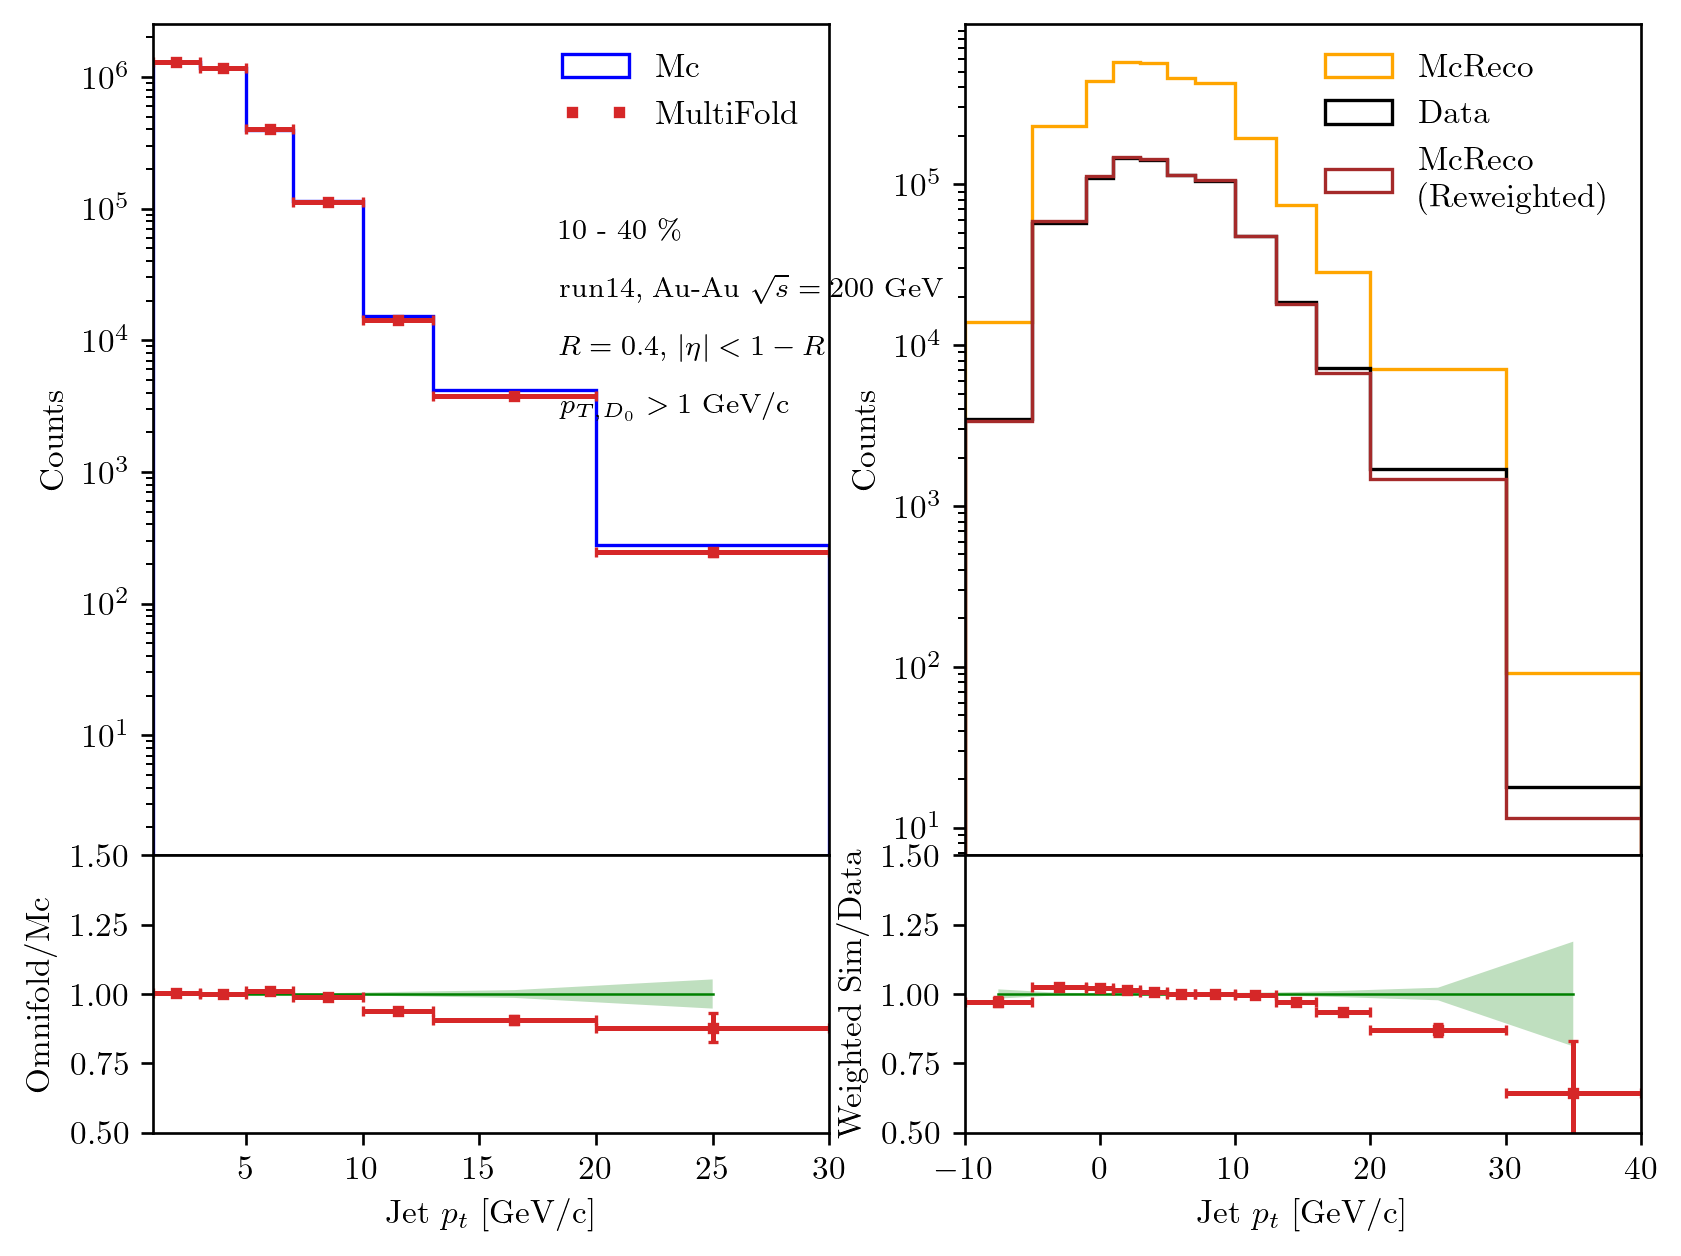

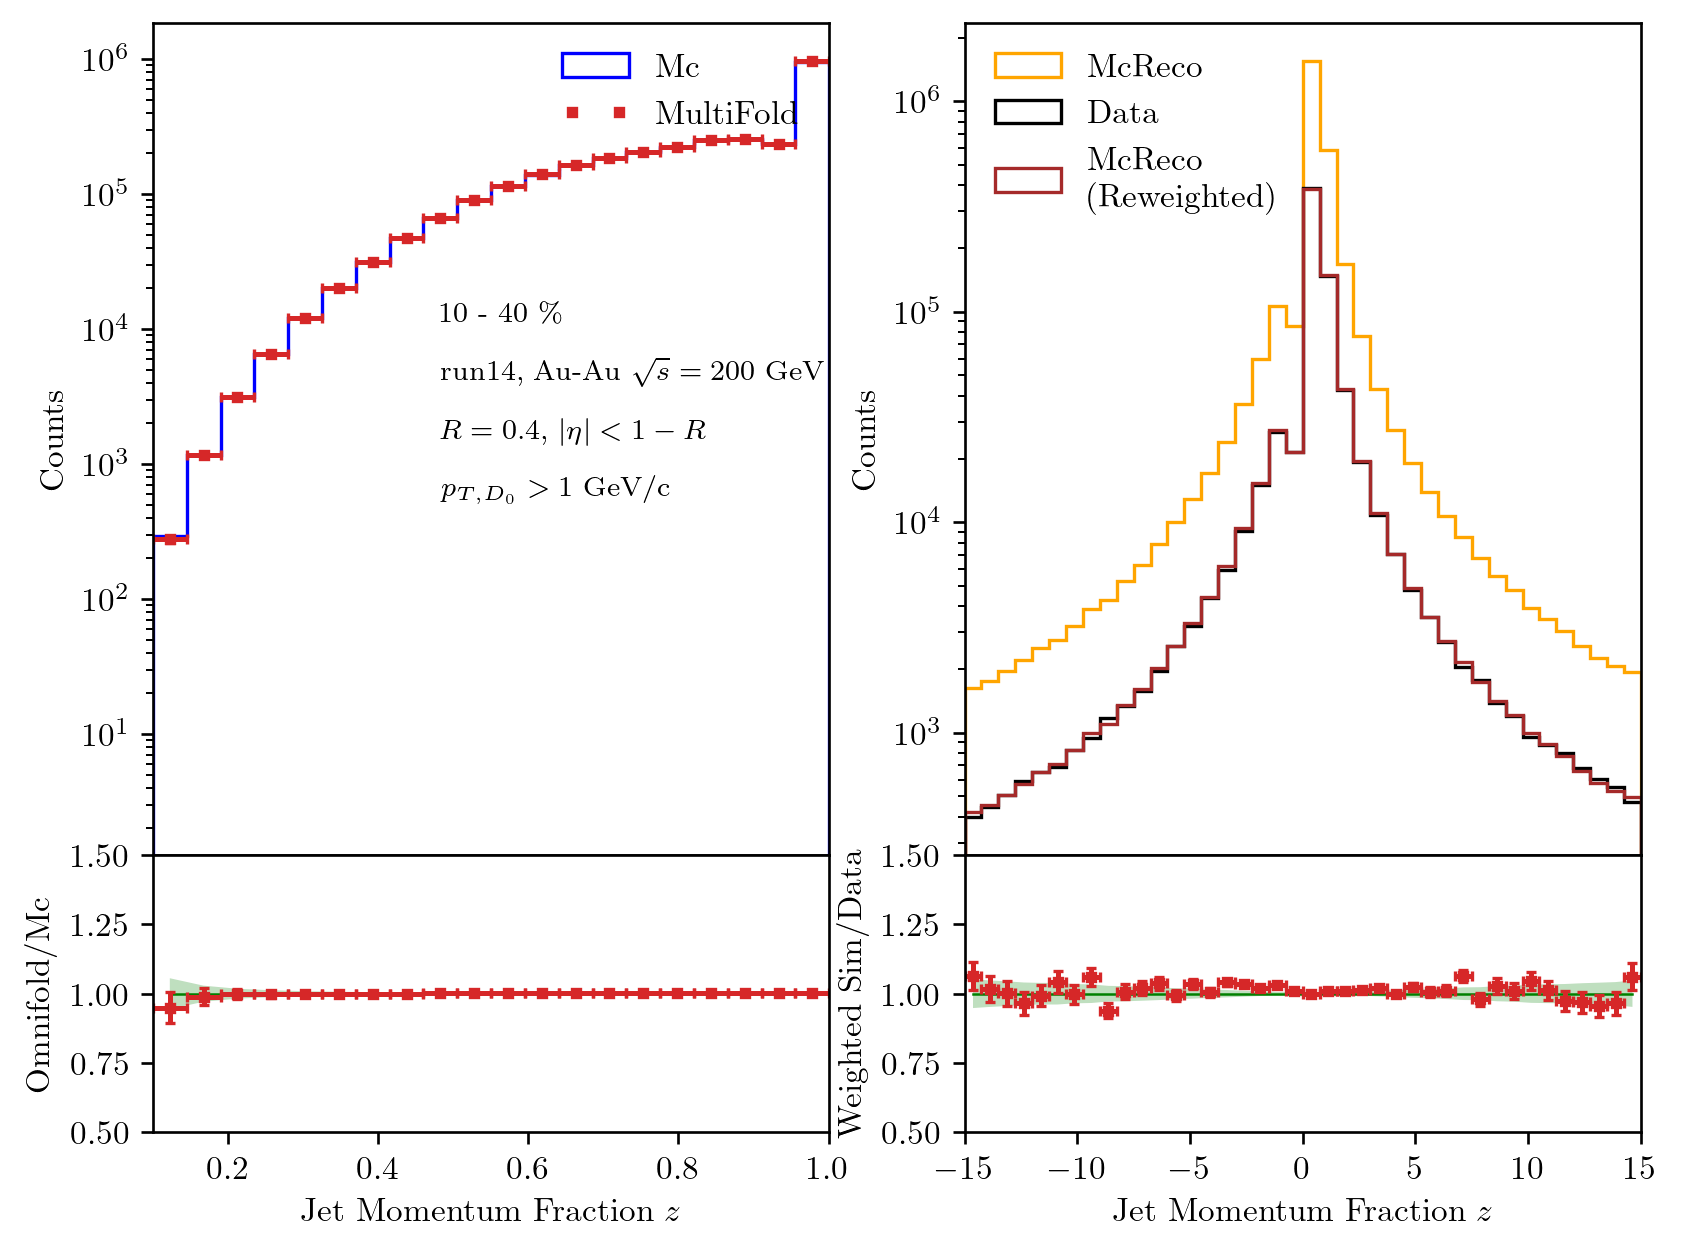

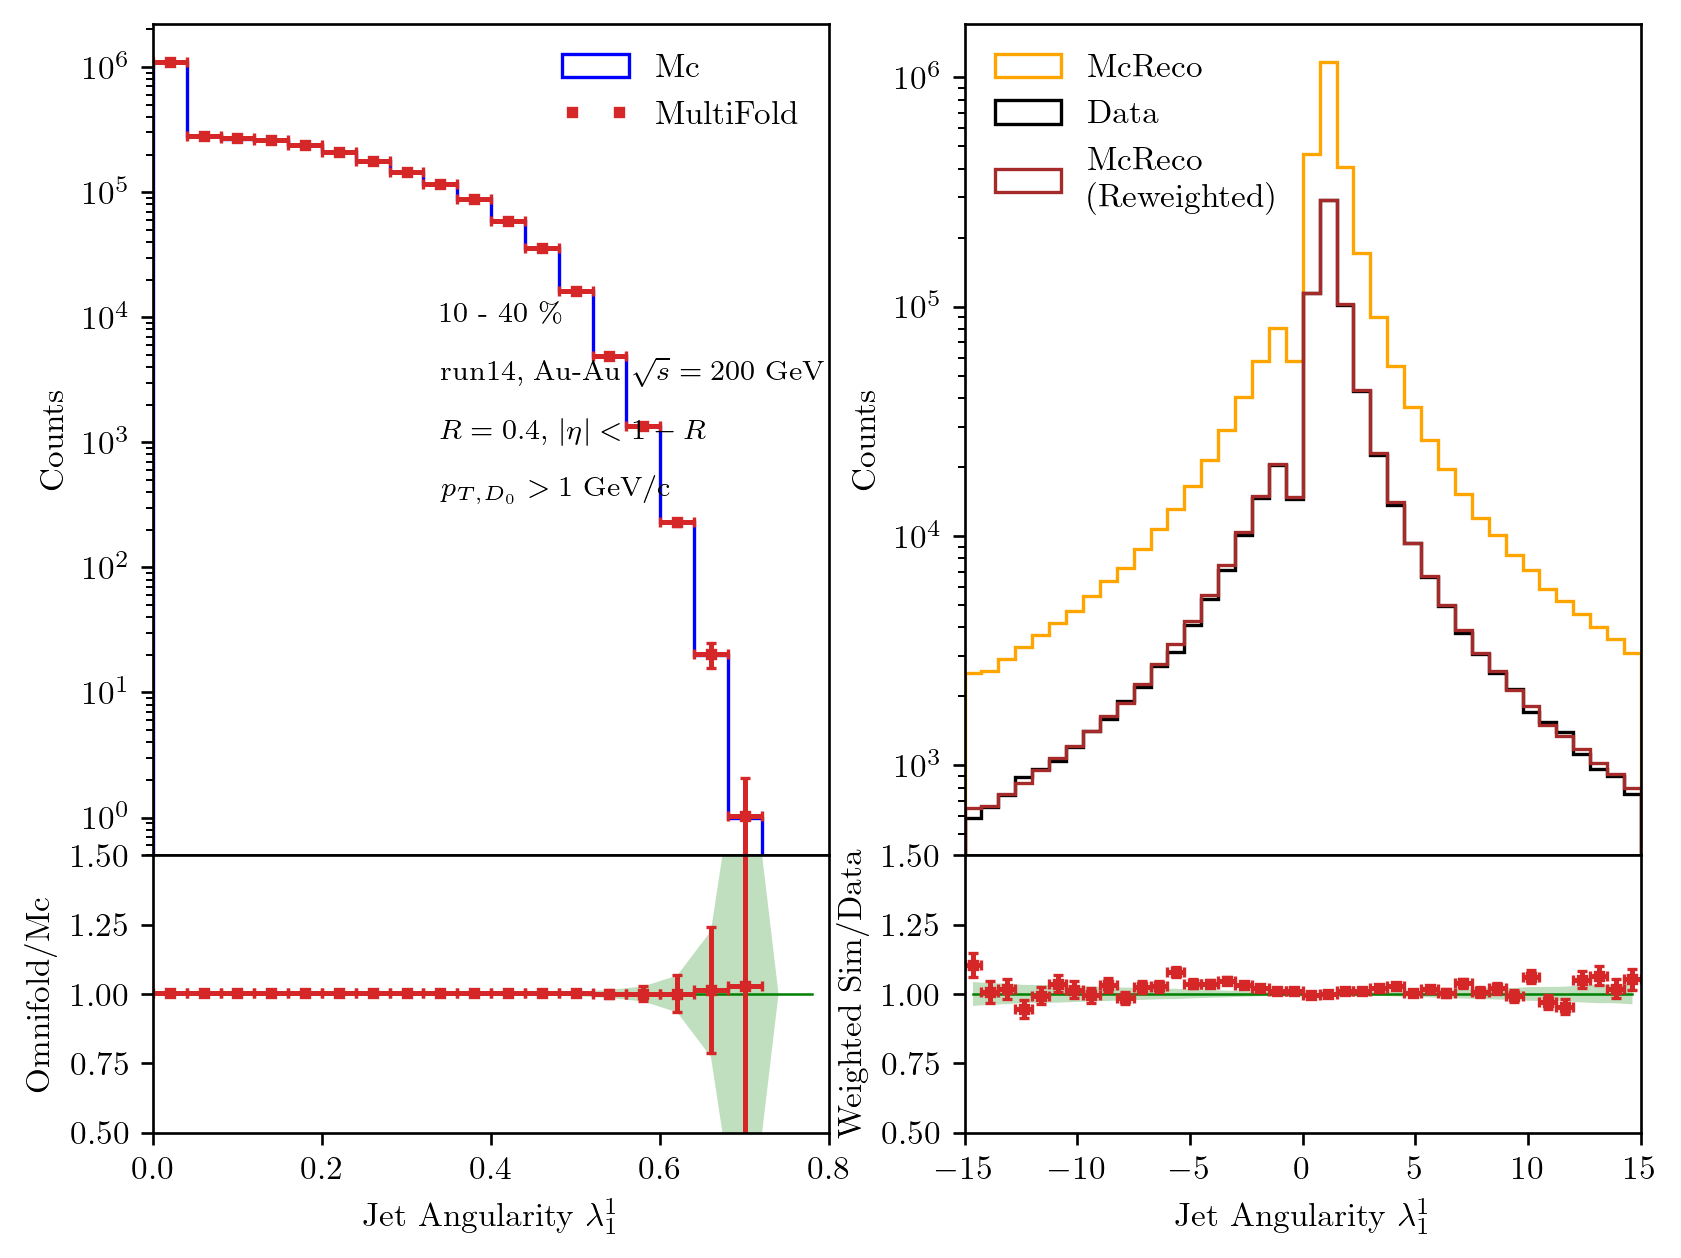

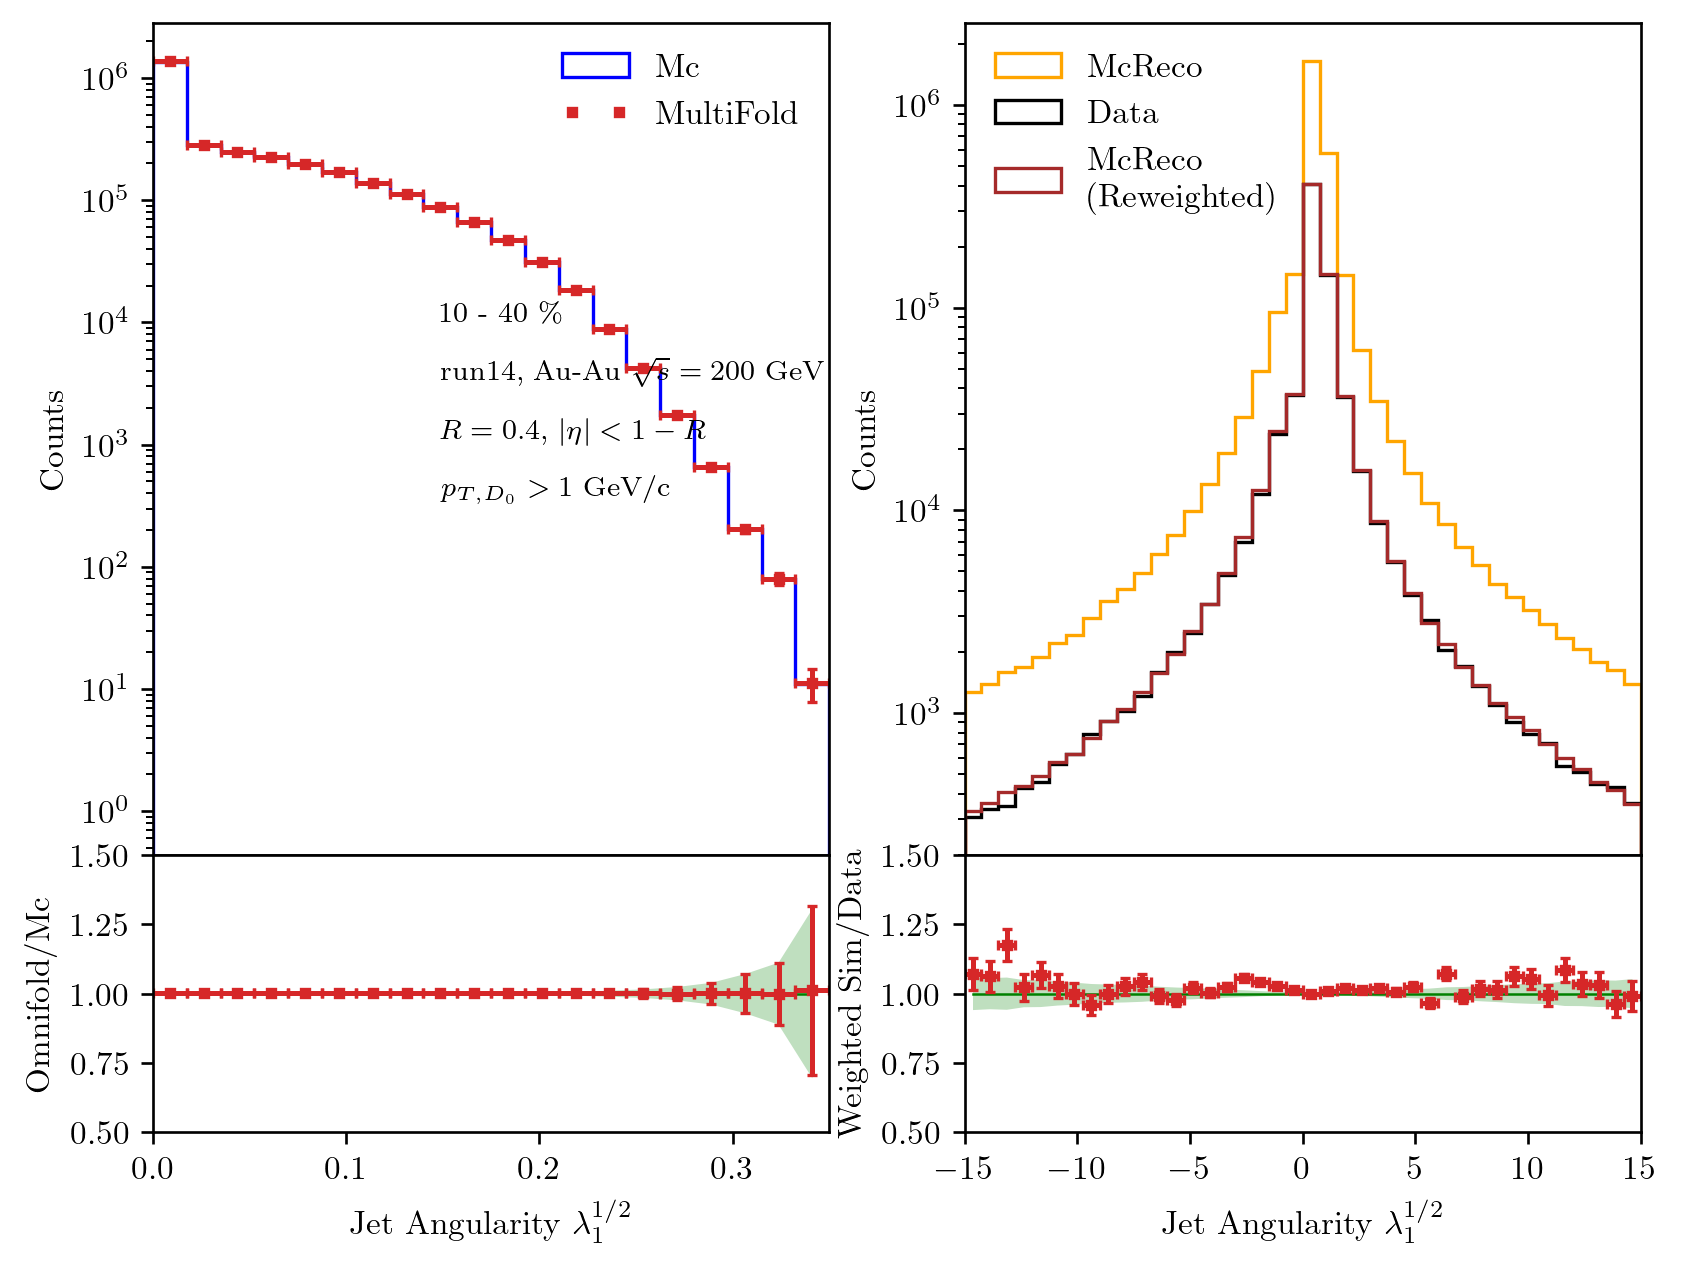

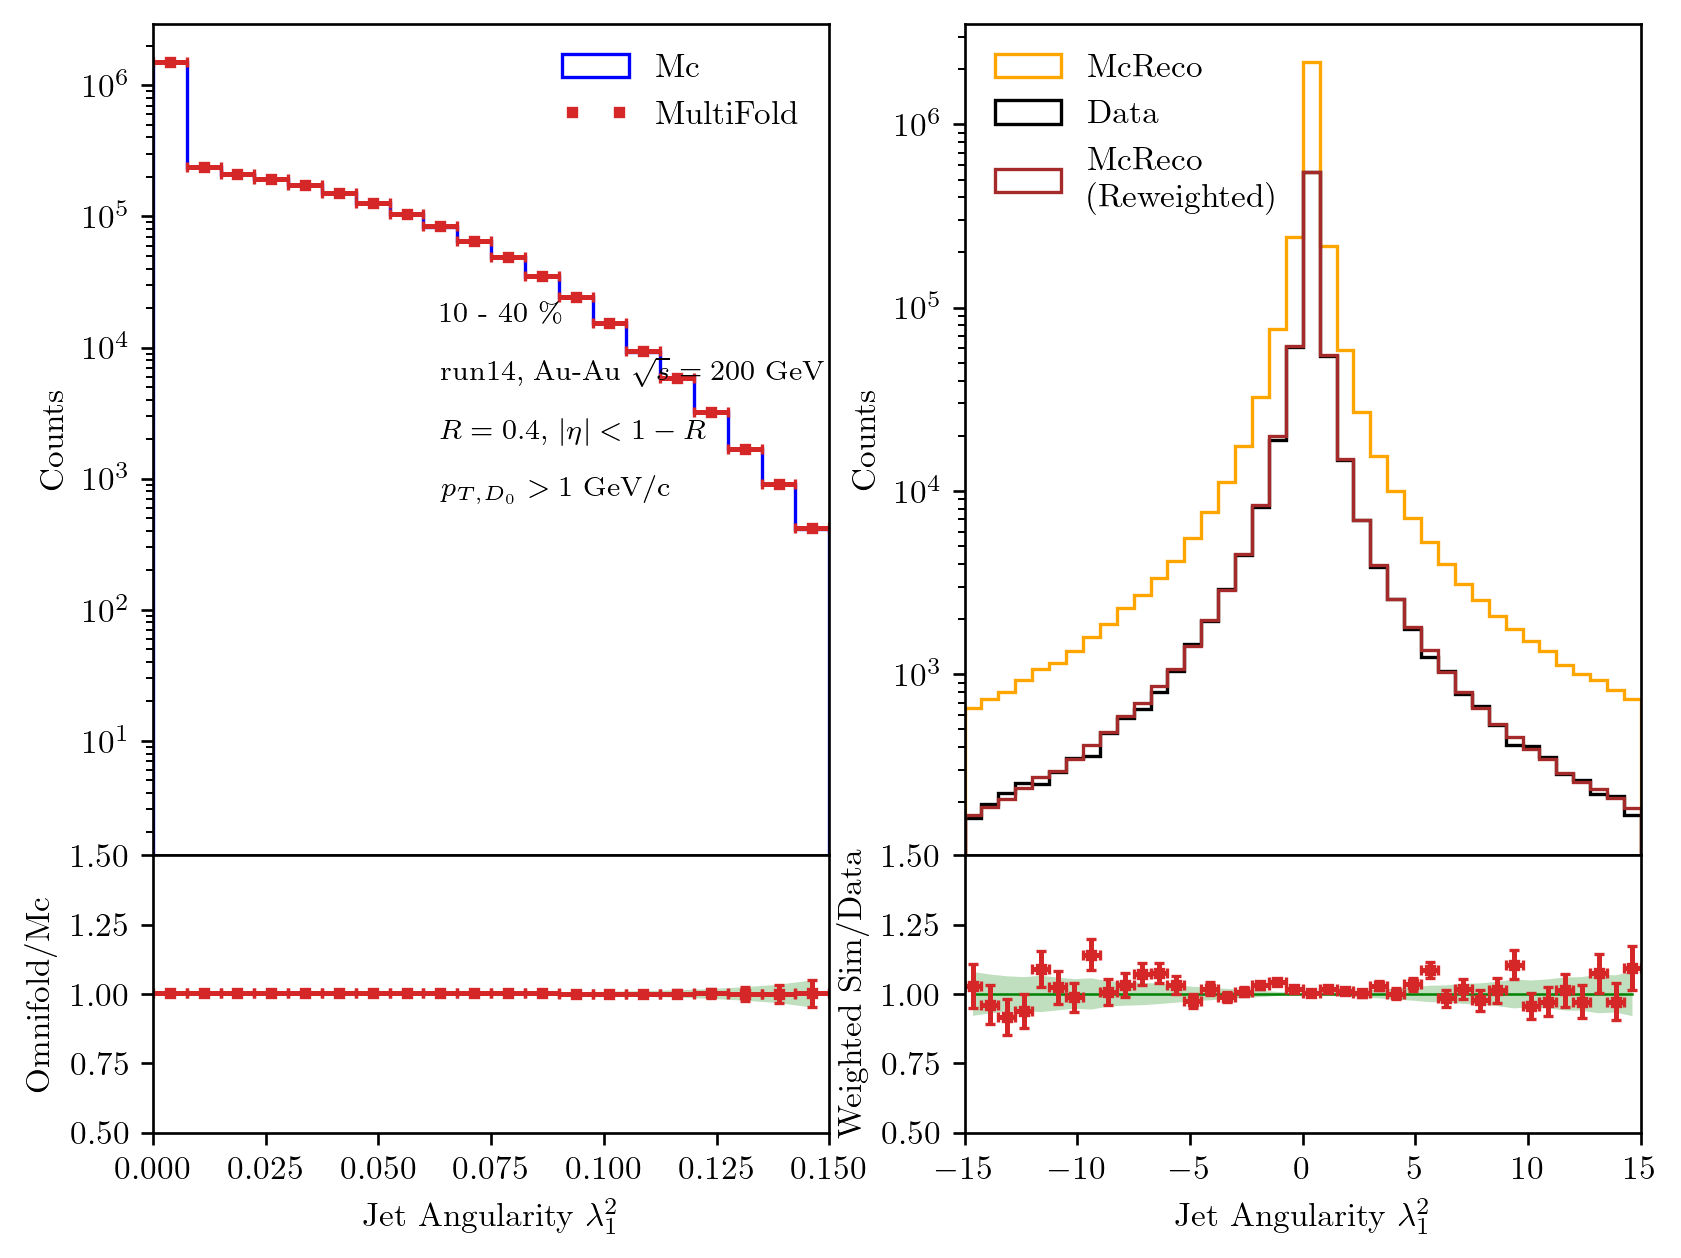

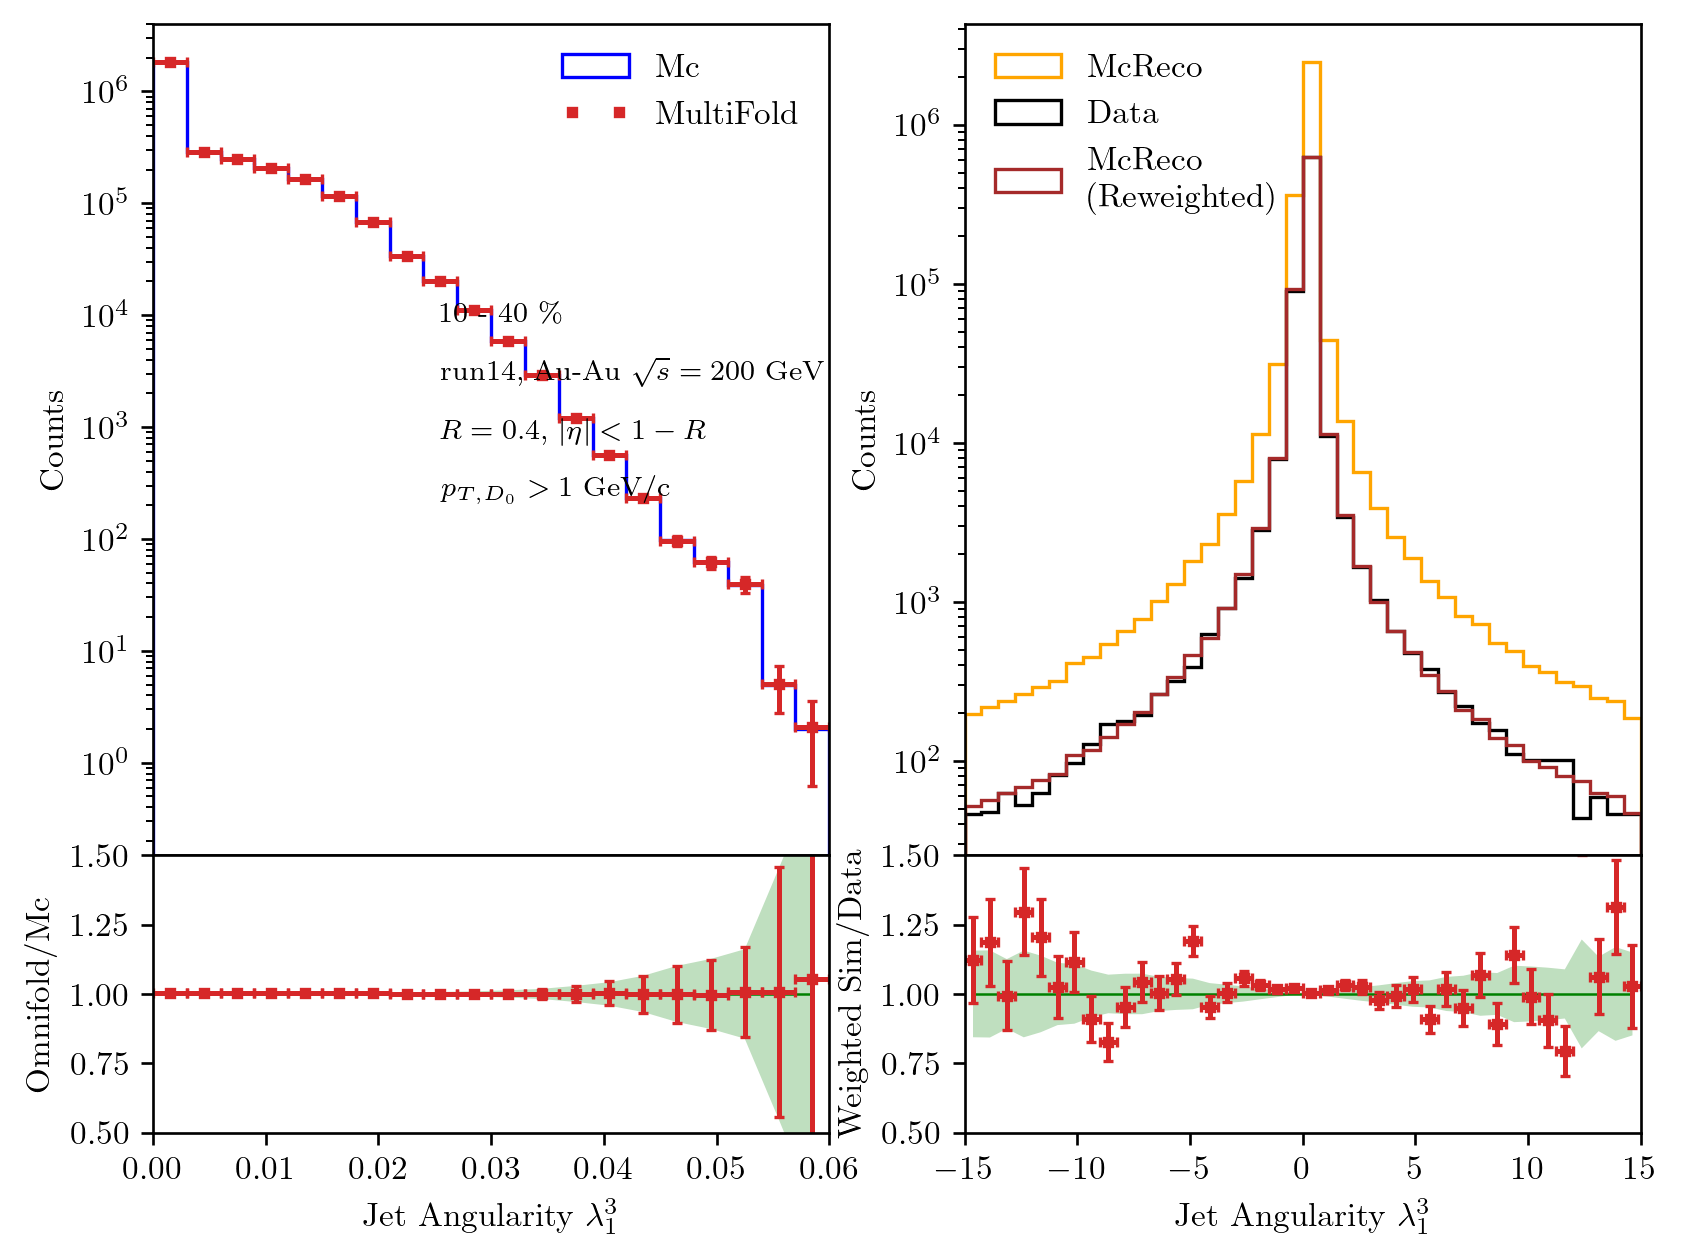

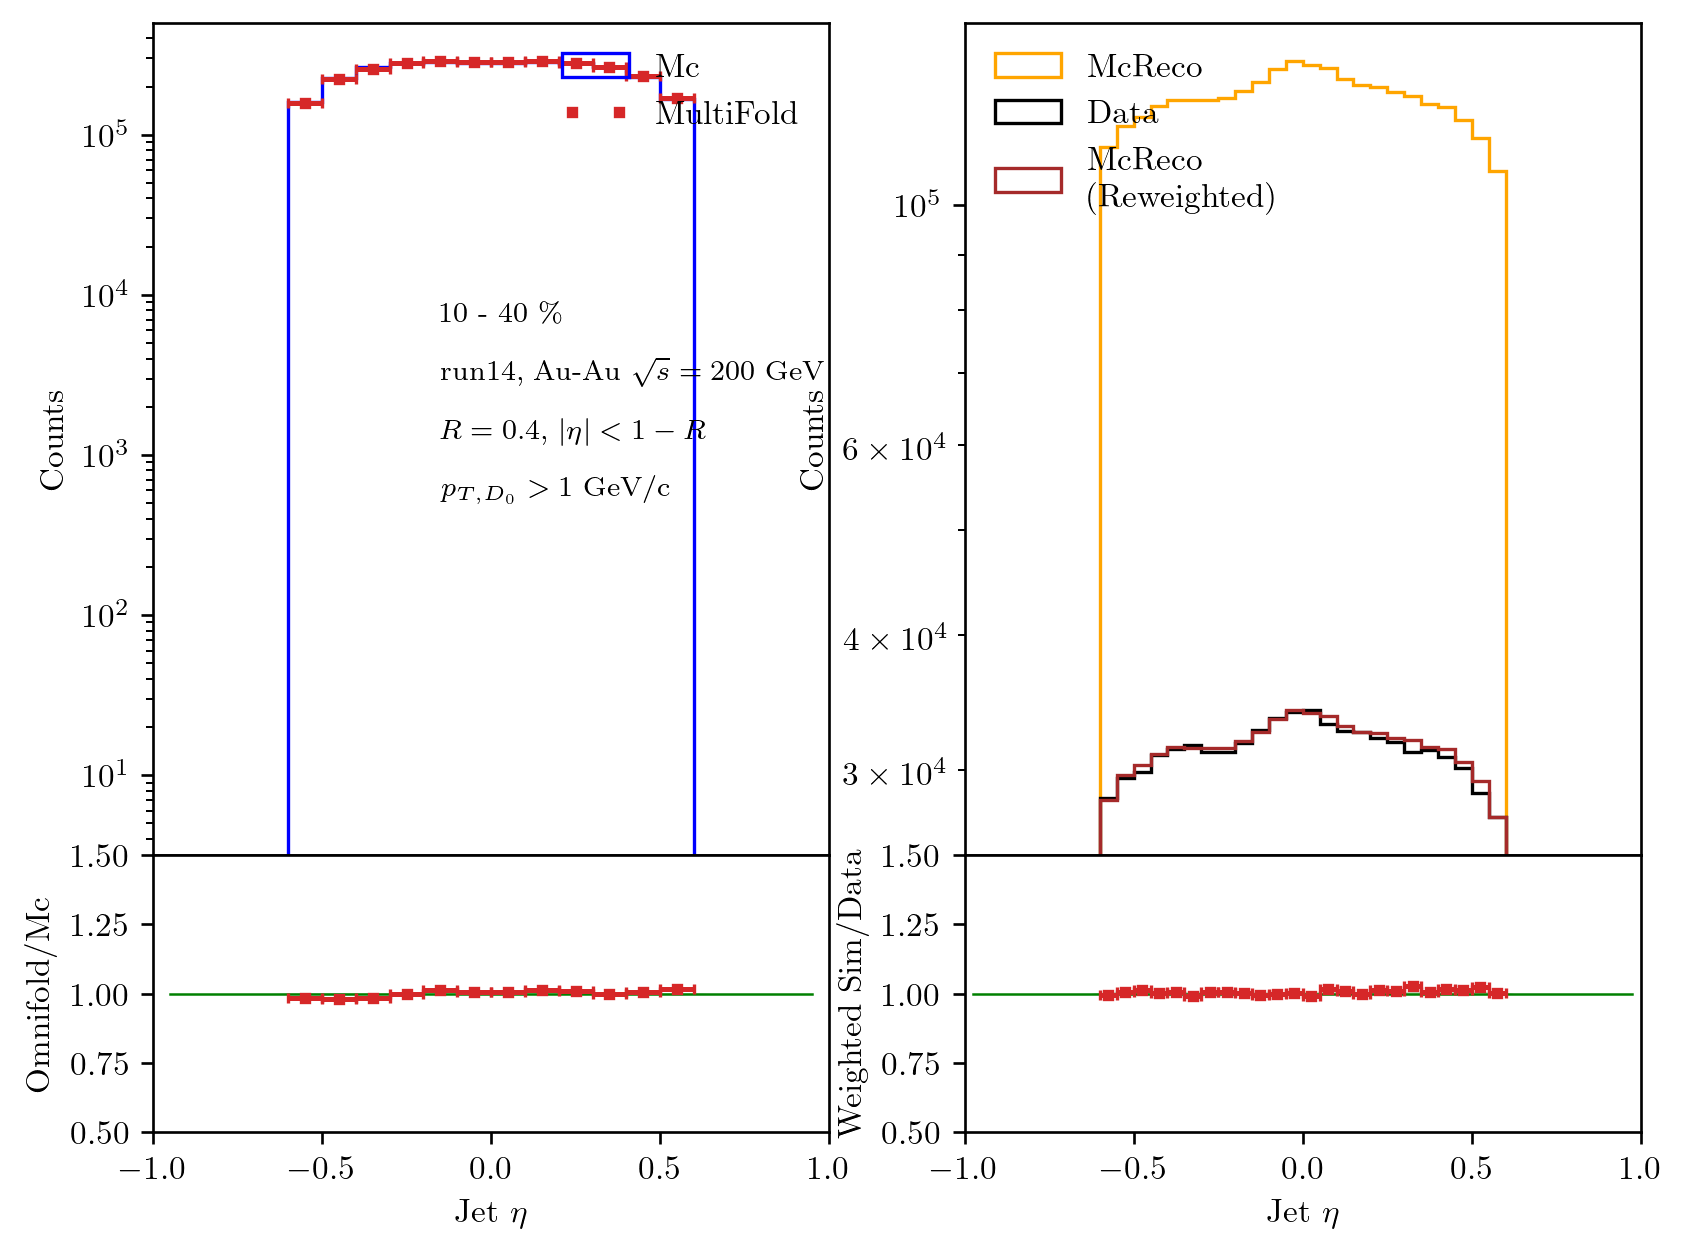

: 

In [33]:
wReweight = weights[selectedIteration,0,:] #weights after last iteration for pull after step 1
wdata = weights[selectedIteration,1,:] #weights after last iteration for push after step 2

for i,(obkey,ob) in enumerate(obs.items()):
    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(2, 2, hspace=0,height_ratios=[3, 1] )
    axs= gs.subplots()
    mcAxis = axs[0,0]
    recoAxis = axs[0,1]
    ratioMcAxis = axs[1,0]
    ratioRecoAxis = axs[1,1]
    # set invisible x axis of mcAxis and recoAxis
    mcAxis.xaxis.set_visible(False)
    recoAxis.xaxis.set_visible(False)
    mcAxis.set_yscale('log')
    recoAxis.set_yscale('log')
    # set x and y limits
    mcAxis.set_xlim(ob['xlim'])
    recoAxis.set_xlim(ob['xlim_det'])
    ratioMcAxis.set_xlim(ob['xlim'])
    ratioRecoAxis.set_xlim(ob['xlim_det'])
    ratioMcAxis.set_ylim(0.5, 1.5)
    ratioRecoAxis.set_ylim(0.5, 1.5)
    # set titles for axis
    ratioMcAxis.set_xlabel(ob['xlabel'])
    ratioMcAxis.set_ylabel('Omnifold/Mc')
    mcAxis.set_ylabel('Counts')
    ratioRecoAxis.set_xlabel(ob['xlabel'])
    ratioRecoAxis.set_ylabel('Weighted Sim/Data')
    recoAxis.set_ylabel(ob['ylabel'])


    # plot the "sim" histogram of the observable
    recoAxis.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='McReco', **hist_style)
    # plot the "data" histogram of the observable
    recoAxis.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='Data', **hist_style)
    # plot the "sim" histogram of the observable
    reweightedSim, edges, _ = recoAxis.hist(ob['simobs'], bins=ob['bins_det'], color='brown', weights=wReweight, label='McReco\n(Reweighted)', **hist_style)
    # ///////////////////////////////////////////////////
    
    mcAxis.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='Mc', **hist_style, density=False)
    # mcAxis.hist(ob['truthobs'], bins=ob['bins_mc'], color='pink', label='Truth Mc', **hist_style, density=False)

    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=wdata, bins=ob['bins_mc'], density=False)[:2]
    mcAxis.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    mcAxis.errorbar(ob['midbins_mc'], of_histgen, xerr=ob['binwidth_mc']/2, yerr=of_histgen_unc, 
                                            color=omnifold_style['color'], **modplot.style('errorbar'))
    
    # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)
    mc_ratio = of_histgen/(ob['genobs_hist']+ 10**-50)
    ratioMcAxis.plot(ob['midbins_mc'], mc_ratio, **omnifold_style)
    ratioMcAxis.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)

    # ratio uncertainties
    mc_ratio_unc = of_histgen_unc/(ob['genobs_hist'] + 10**-50)
    ratioMcAxis.fill_between(ob['midbins_mc'], 1 - mc_ratio_unc, 1 + mc_ratio_unc,
                    facecolor=truth_style['facecolor'], zorder=-2)
    ratioMcAxis.errorbar(ob['midbins_mc'], mc_ratio, xerr=ob['binwidth_mc']/2, yerr=mc_ratio_unc,
                                            color=omnifold_style['color'], **modplot.style('errorbar'))
   
    

    #  ratio of reweighted McReco to Data

   # Plot the Ratios of the Scaled Sim to Data (with statistical uncertainties)
    reco_ratio = reweightedSim/(ob['data_hist']+ 10**-50)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    ratioRecoAxis.plot(bin_centers, reco_ratio, **omnifold_style)
    ratioRecoAxis.plot([np.min(bin_centers), np.max(bin_centers)], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    reco_ratio_unc = np.sqrt(reweightedSim)/(ob['data_hist'] + 10**-50)
    ratioRecoAxis.fill_between(bin_centers, 1 - reco_ratio_unc, 1 + reco_ratio_unc,
                    facecolor=truth_style['facecolor'], zorder=-2)
    ratioRecoAxis.errorbar(bin_centers, reco_ratio, xerr=ob['binwidth_det']/2, yerr=reco_ratio_unc, 
                                            color=omnifold_style['color'], **modplot.style('errorbar'))
 

    # legend style and ordering
    loc = ob.get('legend_loc', 'upper right')
    modplot.legend( ax=mcAxis, frameon=False,  loc=loc, fontsize = 10)
    loc = ob.get('legend_loc', 'upper left')
    modplot.legend( ax=recoAxis, frameon=False,  loc=loc, fontsize = 10)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.07, ax=mcAxis,
    # centrality label
                 line_0=r'{} - {} \%'.format(centralityBins[0], centralityBins[1]), 
                 line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                 line_2=r'$R=0.4$, $|\eta|<1-R$',
                 line_3=r'$p_{T,D_0}>1$ GeV/c')

    if isClosureTest:
        modplot.stamp(0.7, 0.6, delta_y=0.07, ax=ax0, line_0='Closure Test', fontsize=12)
        

    # # save plot (by default in the same directory as this notebook).
    fig.savefig(f"{saveFolder}/omnifold_{obkey}.pdf", bbox_inches='tight')
    plt.show()
